# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет.<br>
<u>Цель работы:</u> научиться определять рыночную стоимость объектов недвижимости и выявить параметры, которые на нее влияют. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. <br>

<u>Примечание</u> <br>
По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

## Описание данных
- airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
- balcony — число балконов
- ceiling_height — высота потолков (м)
- cityCenters_nearest — расстояние до центра города (м)
- days_exposition — сколько дней было размещено объявление (от публикации до снятия)
- first_day_exposition — дата публикации
- floor — этаж
- floors_total — всего этажей в доме
- is_apartment — апартаменты (булев тип)
- kitchen_area — площадь кухни в квадратных метрах (м²)
- last_price — цена на момент снятия с публикации
- living_area — жилая площадь в квадратных метрах (м²)
- locality_name — название населённого пункта
- open_plan — свободная планировка (булев тип)
- parks_around3000 — число парков в радиусе 3 км
- parks_nearest — расстояние до ближайшего парка (м)
- ponds_around3000 — число водоёмов в радиусе 3 км
- ponds_nearest — расстояние до ближайшего водоёма (м)
- rooms — число комнат
- studio — квартира-студия (булев тип)
- total_area — общая площадь квартиры в квадратных метрах (м²)
- total_images — число фотографий квартиры в объявлении

# Импорт библиотек и настройка отображения

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

import sys, warnings
warnings.simplefilter("ignore")

# Функции

In [2]:
def uppercase_split(loc_full_name, return_name = 1):
    '''
    Функция для "разрезания" строк по заглавной букве в столбце (т.е. отделяет тип населенного пункта от его названия.
    Возвращает кортеж, где 0й элемент - тип населенного пункта, 1й - название.
    '''
    loc_name, loc_type = [], []
    loc_full_name = str(loc_full_name).split()
    for idx, word in enumerate(loc_full_name):
        if word.istitle():
            loc_type = loc_full_name[:idx]
            loc_name = loc_full_name[idx:]
            break
    if return_name:
        return ' '.join(loc_name)
    return ' '.join(loc_type)

In [3]:
def type_of_floor(fl, tot_fl):
    '''
    Функция для категоризации этажей
    fl - номер этажа
    tot_fl - всего этажей
    '''
    if fl == 1:
        return 'первый'
    elif fl == tot_fl:
        return 'последний'
    return 'другой'

In [4]:
def plotter(data, column, title_plot, xtitle, limits = True):
    '''
    Функция для печати графиков, где:
        data - датасет
        title_plot - название выводимой величины
        column - название колонки, распределение которой необходимо вывести
        xtitle - подпись оси Х
        limits - ограничивать от минус до плюс трех межквартильльных интервалов или нет. Есть True - ограничивать. 
    '''
    fig, axes = plt.subplots(2, figsize = (15, 6))
    fig.suptitle('Распределение значения - '+title_plot, fontsize=16)

    Q1 =  data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_range = Q1-1.5*IQR
    upper_range = Q3+1.5*IQR
    lowest_range = Q1-3*IQR
    uppest_range = Q3+3*IQR
    ticks_list = np.array(sorted(data.loc[data[column] != 0, column].describe().to_list()[3:]\
                        +[lower_range, upper_range, lowest_range, uppest_range])).round(3)

    sns.histplot(data = data, 
                 x = column,
                 ax = axes[0],
                 kde = True,
                )

    sns.boxplot(data = data, 
                 x = column,
                 ax = axes[1],
                color = 'Yellow',
               )

    for i in [0, 1]:
        axes[i].axvline(x = lowest_range, 
                        color = 'orange',
                       )
        axes[i].axvline(x = uppest_range, 
                        color = 'r',
                       )
        axes[i].grid(True, color = 'grey')
        axes[i].set_xlabel(xtitle, fontsize=14)
        axes[i].set_xticks(ticks_list)
        axes[i].set_xticklabels(axes[0].get_xticks(),rotation = 90)  
        if limits:
            axes[i].set_xlim(lowest_range, uppest_range)

    fig.tight_layout()
    plt.show()
    print(data[column].describe())

# Загрузка данных

In [5]:
try:
    data = pd.read_csv('real_estate_data.csv', sep = '\t')
except:
    try:
        data = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')
    except:
        data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep = '\t')
        print('')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

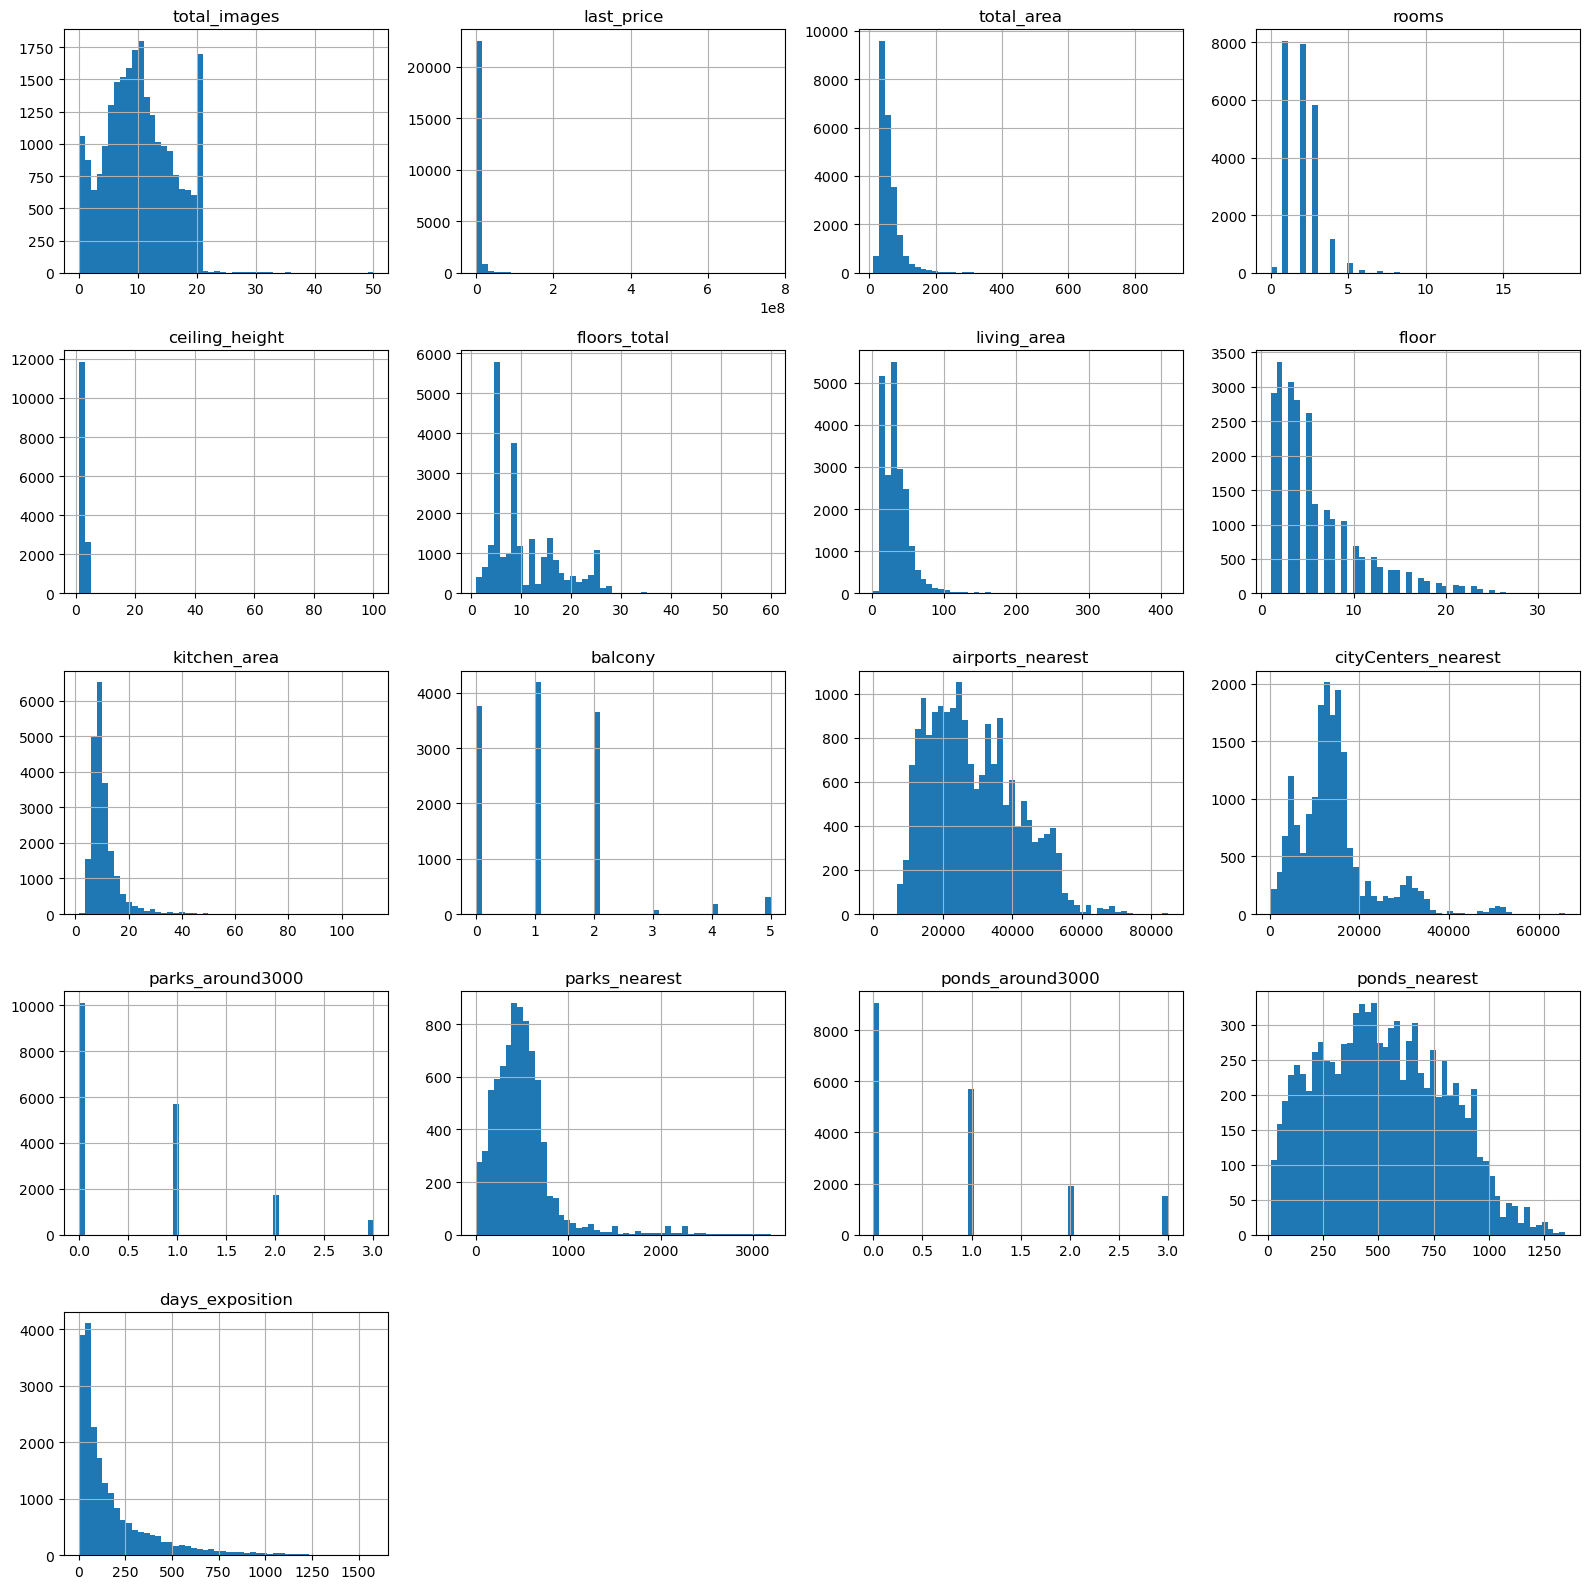

In [7]:
data.hist(bins = 50,
          figsize = (16, 16),
         )
plt.tight_layout()

# Анализ пропусков

In [8]:
display((data.isna().sum()/data.shape[0]*100).round(2).sort_values(ascending = False))

is_apartment            88.29
parks_nearest           65.91
ponds_nearest           61.56
balcony                 48.61
ceiling_height          38.80
airports_nearest        23.38
cityCenters_nearest     23.29
ponds_around3000        23.28
parks_around3000        23.28
days_exposition         13.42
kitchen_area             9.61
living_area              8.03
floors_total             0.36
locality_name            0.21
total_images             0.00
last_price               0.00
studio                   0.00
floor                    0.00
rooms                    0.00
first_day_exposition     0.00
total_area               0.00
open_plan                0.00
dtype: float64

## Анализ результата
<div>
Как видим, много пропущенных значений в столбцах. 

Всего объектов недвижимости - 23699. В таблице процент пропусков от общего количества записей...

Параметр недвижимости                | Не указано, %
------                               | :-------- 
Аппартаменты? (да/нет)               |  **88.29**
Расстояние до ближайшего парка (м)   |  **65.91**
Расстояние до ближайшего водоема (м) |  **61.56**
Количество балконов (шт.)            |  **48.61**
Высота потолков (м)                  |  **38.80**
Расстояние до аэропорта (м)          |  **23.38**
Расстояние до центра (м)             |  **23.29**
Число водоёмов в радиусе 3 км (шт)   |  **23.28**
Число парков в радиусе 3 км (шт)     |  **23.28**
Длительность рамещения объявления (дней) |  **13.42**
Площадь кухни (м.кв.)                |   **9.61**
Жилая площадь (м.кв.)                |   **8.03**
Количество этажей в здании           |   **0.36**
Название населенного пункта          |   **0.21**
</div>

In [9]:
# Статистика по высоте потолков из данной выборки
data.ceiling_height.describe() 

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

In [10]:
# Изучение пропусков в столбце "Наличие аэропорта"
data.query('airports_nearest.isna()')['locality_name'].value_counts().head(20)

посёлок Мурино             522
Всеволожск                 398
Гатчина                    307
деревня Кудрово            299
Выборг                     237
Кудрово                    173
деревня Новое Девяткино    144
Сертолово                  142
Кириши                     125
Сланцы                     112
Волхов                     111
Тосно                      104
Кингисепп                  104
Никольское                  93
Коммунар                    89
Сосновый Бор                87
Санкт-Петербург             85
Кировск                     84
Отрадное                    80
посёлок Бугры               69
Name: locality_name, dtype: int64

# Изучение типов данных

In [11]:
data.dtypes

total_images              int64
last_price              float64
total_area              float64
first_day_exposition     object
rooms                     int64
ceiling_height          float64
floors_total            float64
living_area             float64
floor                     int64
is_apartment             object
studio                     bool
open_plan                  bool
kitchen_area            float64
balcony                 float64
locality_name            object
airports_nearest        float64
cityCenters_nearest     float64
parks_around3000        float64
parks_nearest           float64
ponds_around3000        float64
ponds_nearest           float64
days_exposition         float64
dtype: object

## Анализ результата
<div>

<i>Ряд важных параметров имеют некорректные типы данных, а именно:<br>
    - 'floors_total', 'rooms', 'balcony', 'parks_around3000', 'ponds_around3000', 'days_exposition' имеют тип float,
хотя описывают целочисленные параметры;<br>
    - 'first_day_exposition' имеет тип object, хотя хранит данные о дате и времени.
</i>
</div>

# Изучение явных дубликатов

In [12]:
data.duplicated().sum()

0

## Анализ результата
<div>
<i>Явных дубликатов - <b>нет</b>.</i>
</div>

# Изучение выбросов и аномалий

In [13]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


## Анализ результата
<div>
<i><b>О цене:</b> в большинстве случаев цены варьируются от 3,4 до 6,8 млн.руб., но есть выбросы до 763 млн.руб.</i><br>
<i><b>Об площади и количестве комнат:</b> <br>    
а) общая площать аномально достигает 900 кв.м., жилая площадь превышает 400 кв.м., а площадь кухни 112 кв.м.;<br>    
б) также кажутся странными квартиры с жилой площадью 2 кв.м., или с кухней 1.3 кв.м.,  или с общей площадью 12 кв.м.;<br>
в) также встречаются 19-ти комнатные квартиры.</i><br>
<i><b>О высоте потолков:</b> явные ошибки и опечатки в данных, иначе откуда высота потолка в квартире 1 м или 100 м??</i><br>
<i><b>О длительности продаж:</b> чаще всего квартиры продаются за 95 дней, однако есть случаи, когда длительность размещения объявления достигает 1580 дней 0_о.</i>
</div>

# Предобработка данных

## План действий, основанный на наблюдениях
1. Почти **90 %** объектов имеют пропуск в графе `"Аппартаменты"`, предположим, что ***пропуск*** - это ***False***.
2. На втором месте по пропускам `расстояния до ближайших парков и водоемов` - **61,5%** и **65,9%**, соответственно. Возможно люди не обращают на это внимания. ***Заполняю значением 3000***, так как в таком случае до ближайшего парка и водоема расстояние будет очень велико и не должно скажется на исследовании.
3. `Наличие балкона` не указано почти в **49%** случаев. Предположу, что ***балкона нет***. Для Санкт-Петербурга, например, это не редкость, старый фонд, все таки.
4. `Высоту потолков` можно ***предугадать*** по высотности здания, либо просто ***указав медианное значение***, потому что, по-моему, это не главный показатель. Учитывая то, что *квартильный разброс высоты потолка от 2.52 до 2.8 м*. Хотя в данных присутствуют и большие выбросы, вплоть до 100 м. Об этом позднее.
5. Далее примерно по 23 % пропусков в 4 столбцах: `Расстояние до аэропорта`, `Расстояние до центра`, `Число водоёмов в радиусе 3 км` и в `Число парков в радиусе 3 км`. Рассмотрим по отдельности:

    а) `расстояние до аэропорта` не указано в подавляющем числе случаев тогда, когда в населенном пункте аэропорта либо нет, либо он находится очень далеко. ***Заменю пропущенные значения в таком случае на заглушку np.nan***, что не помешает построению графиков. Кстати, в СПб не указано расстояние до аэропорта только в 85 случаях (0,54%);
    
    б) `расстояние до центра` один из важнейших параметров, определяющий стоимость квадратного метра жилья. ***Заменю на медианное значение по населенному пункту***, но только после того, как названия населенных пунктов будут приведены в порядок;
    
    в) не указано `число парков и водоёмов в радиусе 3 км`, не беда, заменим на ***0***, видимо, их нет, или они не достаточно хороши, чтобы их указывать.
    
    
6. По `длительность рамещения объявления`, пропущенной почти в ***13,4%*** случаев можно предположить, что квартиры все еще в продаже. Этих пропусков довольно много, придется ***заменить их на np.nan***. Так будет понятно, что если 0, то все еще в продаже.
7. Пропущенные значения со значением *`площадей кухни`* и *`жилой площади`* стоит заменить ***медианным значением*** с учетом количества комнат в квартире.
8. Строки со значением `количества этажей в здании` и `названием населенного пункта` пропущены в менее чем 0,5 % случаев. Их можно просто удалить, это никак не повлияет на мой анализ.

In [14]:
# Заполняем значения в столбцах на значения в соответствии с планом
data.is_apartment.fillna(False, inplace = True) # По п.1
data[['parks_nearest','ponds_nearest']] = data[['parks_nearest','ponds_nearest']].fillna(np.nan) # По п.2
data.balcony.fillna(0, inplace = True) # По п.3
data.ceiling_height.fillna(data.ceiling_height.median(), inplace = True) # По п.4
data.airports_nearest.fillna(np.nan, inplace = True) # По п.5 перечисление а)
# По п.5 перечисление б) - будет сделано после корректировки дубликатов в названиях населенных пунктов.
data[['parks_around3000','ponds_around3000']] = data[['parks_around3000','ponds_around3000']].fillna(0) # По п.5 перечисление в)
data.days_exposition.fillna(0, inplace = True) # По п.6

for t in data['rooms'].unique():  # По п.7
    data.loc[(data['rooms'] == t) & (data['kitchen_area'].isna()), 'kitchen_area'] = \
    data.loc[(data['rooms'] == t), 'kitchen_area'].median()
   
for t in data['rooms'].unique():  # По п.7
    data.loc[(data['rooms'] == t) & (data['living_area'].isna()), 'living_area'] = \
    data.loc[(data['rooms'] == t), 'living_area'].median()
# По п.8 будет сделано после корректировки дубликатов в названиях населенных пунктов.
 
(data.isna().sum()/data.shape[0]*100).round(2).sort_values(ascending = False)

parks_nearest           65.91
ponds_nearest           61.56
airports_nearest        23.38
cityCenters_nearest     23.29
kitchen_area             0.83
floors_total             0.36
locality_name            0.21
total_images             0.00
ponds_around3000         0.00
parks_around3000         0.00
balcony                  0.00
open_plan                0.00
last_price               0.00
studio                   0.00
is_apartment             0.00
floor                    0.00
living_area              0.00
ceiling_height           0.00
rooms                    0.00
first_day_exposition     0.00
total_area               0.00
days_exposition          0.00
dtype: float64

<div>
Итого, избавились от части пропусков. Пока достаточно.
</div>

## Изучение и устранение неявных дубликатов

<div>
Изменю порядок предобработки, чтобы доделать предыдущий пункт.
Для справки, неявные дубликаты, это, например, «поселок Рябово» и «поселок городского типа Рябово», «поселок Тельмана» и «посёлок Тельмана» — это обозначения одних и тех же населённых пунктов.
</div>

In [15]:
data['locality_name'] = data['locality_name'].str.replace('ё','е') # Уберем все точки над "е"

In [16]:
data['locality_only_name'] = data['locality_name'].apply(uppercase_split, return_name = 1)
data['locality_type'] = data['locality_name'].apply(uppercase_split, return_name = 0)
data = data.reindex(columns = ['total_images', 'last_price', 'living_area','total_area', 'kitchen_area', 'floor', 
       'first_day_exposition', 'rooms', 'ceiling_height', 'floors_total', 
       'is_apartment', 'studio', 'open_plan', 'balcony',
       'locality_type', 'locality_only_name', 'locality_name',
        'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'])
data = data.rename(columns = {'locality_only_name': 'locality_name', 'locality_name': 'locality_full_name'})

In [17]:
data = data.query('locality_name != ""') # Удалил пустые строки с названием города.
# Итого получилась таблица со столбцом, содержащим только уникальные значения названий населенных пунктов 
display(data.sample(20))
print(f'Всего таких населенных пунктов: {len(data.locality_name.unique())}')

,total_images,last_price,living_area,total_area,kitchen_area,floor,first_day_exposition,rooms,ceiling_height,floors_total,is_apartment,studio,open_plan,balcony,locality_type,locality_name,locality_full_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
14399,20,10990000.0,50.9,97.0,15.30,14,2018-02-11T00:00:00,3,2.80,23.0,False,False,False,0.0,,Санкт-Петербург,Санкт-Петербург,32279.0,12790.0,0.0,NaN,0.0,NaN,345.0
16821,20,5100000.0,30.5,47.8,7.00,2,2018-08-15T00:00:00,2,2.60,9.0,False,False,False,1.0,,Санкт-Петербург,Санкт-Петербург,40808.0,13312.0,0.0,NaN,0.0,NaN,142.0
15919,7,10338200.0,17.6,65.0,9.04,4,2018-12-26T00:00:00,1,2.65,10.0,False,False,False,0.0,,Санкт-Петербург,Санкт-Петербург,NaN,NaN,0.0,NaN,0.0,NaN,0.0
20964,20,10398000.0,33.7,56.7,11.40,1,2019-03-20T00:00:00,1,3.60,3.0,False,False,False,0.0,,Санкт-Петербург,Санкт-Петербург,24796.0,3402.0,3.0,522.0,2.0,365.0,0.0
7526,2,4595000.0,48.4,78.8,13.00,5,2018-03-12T00:00:00,3,2.65,5.0,False,False,False,0.0,,Всеволожск,Всеволожск,NaN,NaN,0.0,NaN,0.0,NaN,8.0
18558,13,4600000.0,49.6,80.0,10.60,8,2017-10-20T00:00:00,3,2.55,10.0,False,False,False,2.0,поселок городского типа имени,Свердлова,поселок городского типа имени Свердлова,NaN,NaN,0.0,NaN,0.0,NaN,139.0
20139,0,5450000.0,52.0,74.0,6.20,3,2017-06-23T00:00:00,4,2.65,9.0,False,False,False,0.0,,Санкт-Петербург,Санкт-Петербург,22089.0,16209.0,0.0,NaN,1.0,781.0,33.0
14093,7,9500000.0,76.0,100.0,10.00,5,2015-02-19T00:00:00,4,3.00,5.0,False,False,False,0.0,,Санкт-Петербург,Санкт-Петербург,25950.0,4798.0,1.0,690.0,0.0,NaN,1497.0
22487,15,4900000.0,28.0,47.1,8.00,12,2018-01-16T00:00:00,2,2.60,15.0,False,False,False,1.0,,Санкт-Петербург,Санкт-Петербург,22332.0,9220.0,0.0,NaN,2.0,315.0,196.0
7334,9,3500000.0,30.6,62.0,12.60,5,2016-04-10T00:00:00,2,2.65,5.0,False,False,False,0.0,поселок,Мурино,поселок Мурино,NaN,NaN,0.0,NaN,0.0,NaN,113.0


Всего таких населенных пунктов: 305


<div>
<b><i>Итак, настало время дообработать пропуски в данных ;)</i></b>

*Напомню, расстояние до центра планировалось заменить на медианное значение по населенному пункту, а потом удалить все оставшиеся пустые значения, так как их почти не останется в таблице. Приступим.* 
</div>

In [18]:
for t in data['locality_name'].unique():  # По п.5 перечисление б)
    data.loc[(data['locality_name'] == t) & (data['cityCenters_nearest'].isna()), 'cityCenters_nearest'] = \
    data.loc[(data['locality_name'] == t) & (~data['cityCenters_nearest'].isna()), 'cityCenters_nearest'].median()

distances_median = data.groupby('locality_name')['cityCenters_nearest'].median()
distances_median = distances_median.reset_index()
display(distances_median.sample(30))
100 - distances_median.cityCenters_nearest.isna().sum()/len(distances_median.cityCenters_nearest)*100

,locality_name,cityCenters_nearest
42,Гатчина,NaN
112,Лаврики,NaN
35,Выборг,NaN
186,Плоское,NaN
159,Новолисино,NaN
94,Коркино,NaN
126,Луга,NaN
236,Сертолово,NaN
192,Починок,NaN
153,Никольский,NaN


8.85245901639344

<div>
Как видим, часть пропусков удалось заменить медианным значением (менее 9 % от всех). Остальные заменю "заглушкой" - 0.
</div>

In [19]:
data['cityCenters_nearest'].fillna(0, inplace = True)

In [20]:
print('Пропуски позаполняли, вот и результат: ')
(data.isna().sum()/data.shape[0]*100).round(2).sort_values(ascending = False)

Пропуски позаполняли, вот и результат: 


parks_nearest           65.90
ponds_nearest           61.59
airports_nearest        23.40
kitchen_area             0.83
floors_total             0.36
total_images             0.00
balcony                  0.00
ponds_around3000         0.00
parks_around3000         0.00
cityCenters_nearest      0.00
locality_full_name       0.00
locality_name            0.00
locality_type            0.00
open_plan                0.00
last_price               0.00
studio                   0.00
is_apartment             0.00
ceiling_height           0.00
rooms                    0.00
first_day_exposition     0.00
floor                    0.00
total_area               0.00
living_area              0.00
days_exposition          0.00
dtype: float64

<div>
Теперь просто удалим строки с пропусками, их осталось очень мало, менее 1 %.
</div>    

In [21]:
data.dropna(inplace = True)
data.reset_index(drop = True)
data.isna().sum().sum()

0

## Исследование типов данных

In [22]:
display(data.dtypes)
data.select_dtypes('float64').columns

total_images              int64
last_price              float64
living_area             float64
total_area              float64
kitchen_area            float64
floor                     int64
first_day_exposition     object
rooms                     int64
ceiling_height          float64
floors_total            float64
is_apartment               bool
studio                     bool
open_plan                  bool
balcony                 float64
locality_type            object
locality_name            object
locality_full_name       object
airports_nearest        float64
cityCenters_nearest     float64
parks_around3000        float64
parks_nearest           float64
ponds_around3000        float64
ponds_nearest           float64
days_exposition         float64
dtype: object

Index(['last_price', 'living_area', 'total_area', 'kitchen_area',
       'ceiling_height', 'floors_total', 'balcony', 'airports_nearest',
       'cityCenters_nearest', 'parks_around3000', 'parks_nearest',
       'ponds_around3000', 'ponds_nearest', 'days_exposition'],
      dtype='object')

<div>
Необходимо изменить на целочисленный тип значения столбцов:<br>
- <i><mark>floors_total</mark>, <mark>last_price</mark>, <mark>rooms</mark>, <mark>balcony</mark>, <mark>parks_around3000</mark>, <mark>ponds_around3000, <mark>days_exposition</mark></i>
</div> 


In [23]:
for col in ['floors_total', 'last_price', 'rooms', 'balcony', 'parks_around3000', 'ponds_around3000', 'days_exposition']:
    data[col] = data[col].astype(int)

data[['floors_total', 'last_price', 'rooms', 'balcony', 'parks_around3000', 'ponds_around3000', 'days_exposition']].dtypes

floors_total        int32
last_price          int32
rooms               int32
balcony             int32
parks_around3000    int32
ponds_around3000    int32
days_exposition     int32
dtype: object

<div>
Теперь необходимо изменить тип данных в столбцах с датами, т.е. в <mark>first_day_exposition</mark>
</div> 

In [24]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data.sample(20)

,total_images,last_price,living_area,total_area,kitchen_area,floor,first_day_exposition,rooms,ceiling_height,floors_total,is_apartment,studio,open_plan,balcony,locality_type,locality_name,locality_full_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
8048,1,6233148,18.95,49.20,13.60,7,2015-03-10,1,3.10,16,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,37407.0,8434.0,1,456.0,2,454.0,483
18233,14,7500000,33.00,54.00,8.00,3,2017-12-03,2,2.65,14,False,False,False,1,,Санкт-Петербург,Санкт-Петербург,28982.0,7921.0,2,186.0,2,327.0,0
3659,10,3090000,22.00,30.00,5.30,1,2017-11-12,1,2.65,5,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,35643.0,9886.0,2,373.0,3,398.0,23
9114,3,8800000,65.40,94.50,8.60,4,2018-03-20,4,3.00,4,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,24643.0,2447.0,3,328.0,3,626.0,151
17924,12,9000000,21.06,68.61,28.64,2,2018-11-27,2,2.70,15,False,False,False,2,,Санкт-Петербург,Санкт-Петербург,29693.0,8632.0,2,729.0,2,356.0,60
14210,24,43511000,35.20,122.08,26.00,1,2017-08-17,1,2.65,7,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,32863.0,5955.0,2,230.0,3,215.0,5
22475,9,4900000,20.00,45.50,14.00,3,2019-02-26,1,2.70,10,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,35966.0,16267.0,1,450.0,3,309.0,0
6293,19,17800000,46.00,86.00,16.00,5,2019-03-26,1,3.00,7,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,24522.0,5090.0,1,479.0,1,846.0,0
17738,1,11894400,38.40,70.80,10.63,12,2019-03-19,2,3.10,16,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,37434.0,8460.0,1,441.0,2,427.0,17
22428,16,4600000,28.40,44.00,7.00,8,2017-07-27,2,2.50,12,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,43879.0,10602.0,2,279.0,1,776.0,90


# Исследование и устранение аномалий
<div>
Аномалиями могут быть, например, значения в столбце <mark>ceiling_height</mark> может быть указана высота потолков 25 м и 32 м. Логично предположить, что на самом деле это вещественные значения: 2.5 м и 3.2 м.
</div>

## Высота потолков

In [25]:
data.loc[data['ceiling_height'] >= 16, 'ceiling_height'] = data.loc[data['ceiling_height'] >= 16, 'ceiling_height']/10

In [26]:
print(data.ceiling_height.describe()['50%'] - data.ceiling_height.describe()['std']) # Медиана минус стандартное отклонение
print(data.ceiling_height.describe()['50%'] + data.ceiling_height.describe()['std']) # Медиана плюс стандартное отклонение
data.ceiling_height.describe() # ну и посмотрим, насколько эти значения похожи на квартили.

2.309281989567178
2.990718010432822


count    4767.000000
mean        2.782935
std         0.340718
min         1.000000
25%         2.650000
50%         2.650000
75%         2.900000
max        10.300000
Name: ceiling_height, dtype: float64

In [27]:
# Теперь посчитаю, сколько значений не входят в диапазон от 2,4 до 2,9 м
low_ceilings = data.query('2.4 > ceiling_height')['ceiling_height'].count()/data['ceiling_height'].count()
hight_ceilings = data.query('ceiling_height > 2.9')['ceiling_height'].count()/data['ceiling_height'].count()
print(f'Ниже 2.4 метра потолки у {low_ceilings:.2%} квартир.')
print(f'Выше 2.9 метров потолки у {hight_ceilings:.2%} квартир.')

Ниже 2.4 метра потолки у 0.08% квартир.
Выше 2.9 метров потолки у 23.98% квартир.


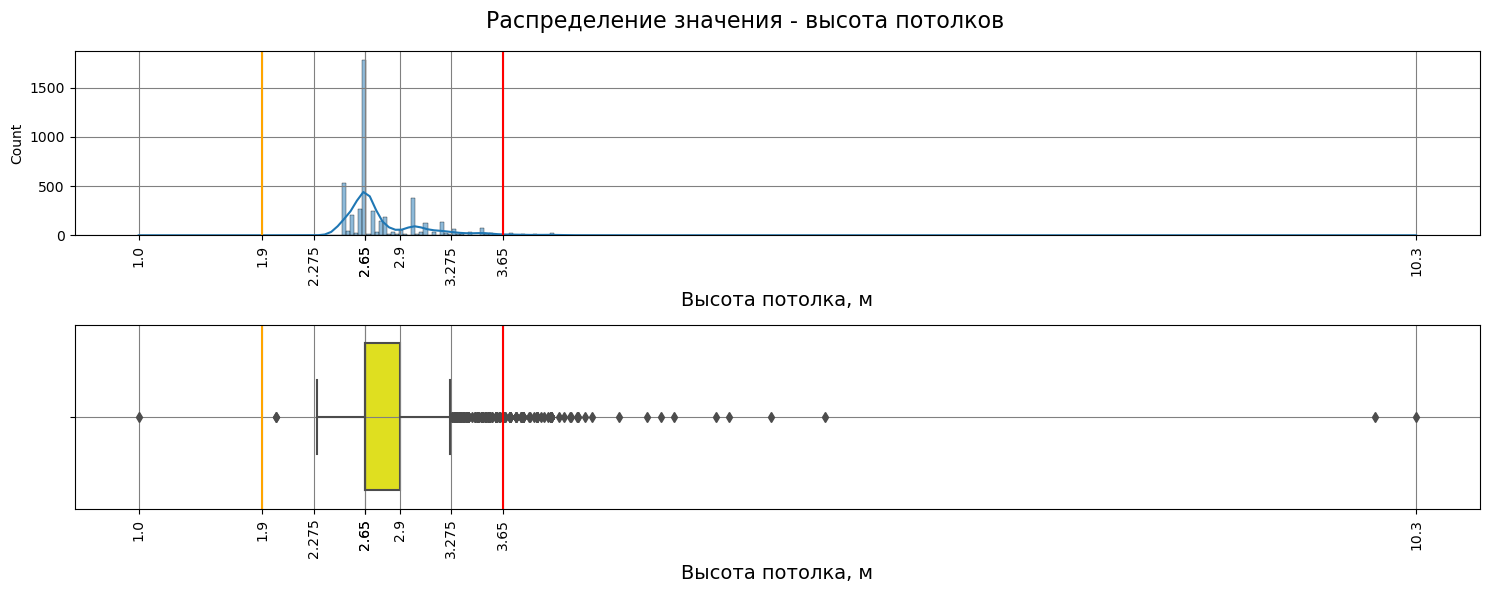

count    4767.000000
mean        2.782935
std         0.340718
min         1.000000
25%         2.650000
50%         2.650000
75%         2.900000
max        10.300000
Name: ceiling_height, dtype: float64


In [28]:
plotter(data = data,
        column = 'ceiling_height', 
        title_plot = 'высота потолков', 
        xtitle = 'Высота потолка, м',
        limits=False,
       )

In [29]:
print('Из всех значений квартир с высотой потолка ниже 2.4 и выше 4.5 метров всего: ', data.query('4.5 <= ceiling_height | ceiling_height <= 2.4')['ceiling_height'].count())
print('И вот как они портят наш график. Удалим их.')

Из всех значений квартир с высотой потолка ниже 2.4 и выше 4.5 метров всего:  22
И вот как они портят наш график. Удалим их.


In [30]:
data = data.query('2.4 < ceiling_height <= 4.5') # Отрезаем лишнее

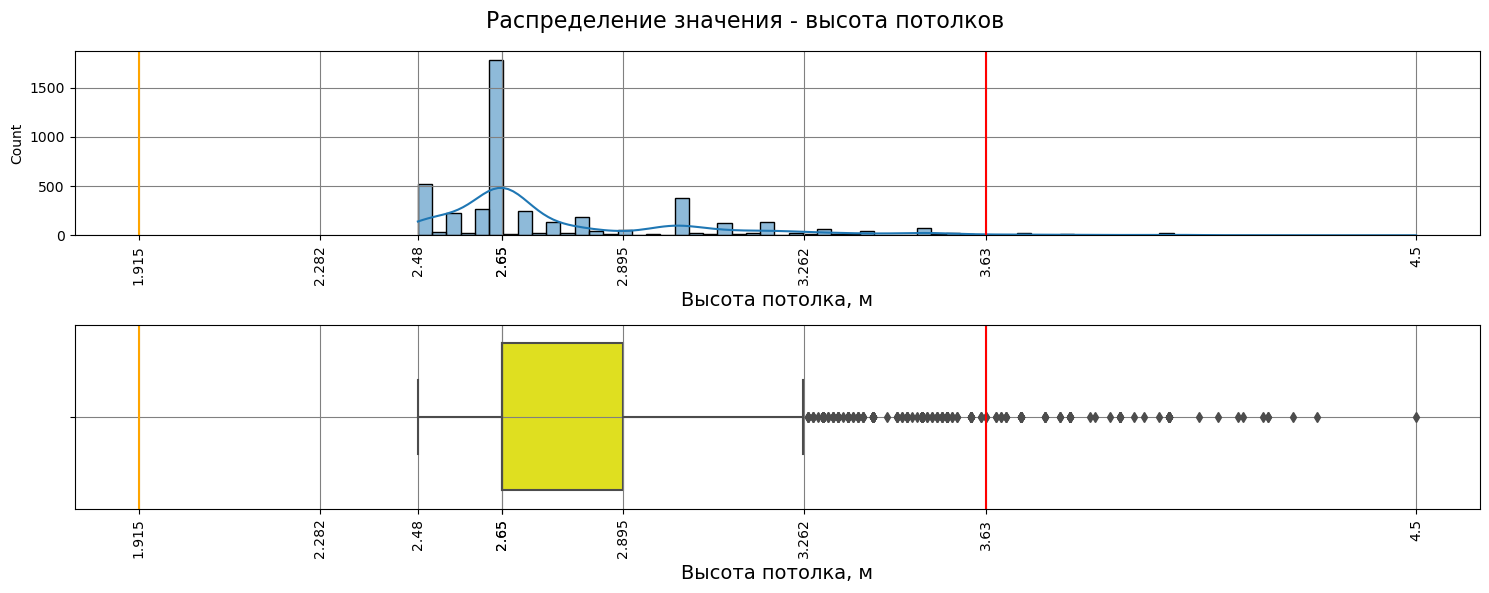

count    4746.000000
mean        2.777697
std         0.288909
min         2.480000
25%         2.650000
50%         2.650000
75%         2.895000
max         4.500000
Name: ceiling_height, dtype: float64


In [31]:
plotter(data = data,
        column = 'ceiling_height', 
        title_plot = 'высота потолков', 
        xtitle = 'Высота потолка, м',
        limits=False,
       )

## Общая площадь

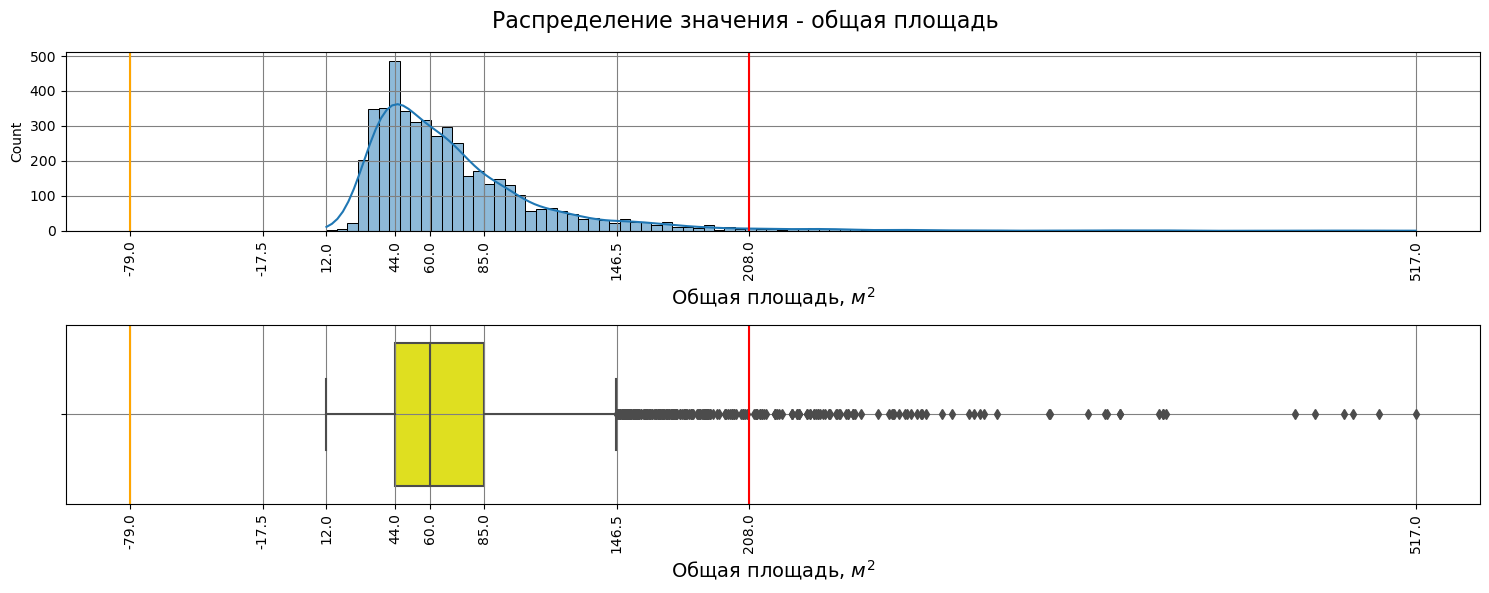

count    4746.000000
mean       72.250512
std        45.376590
min        12.000000
25%        44.000000
50%        60.000000
75%        85.000000
max       517.000000
Name: total_area, dtype: float64


In [32]:
plotter(data = data,
        column = 'total_area', 
        title_plot = 'общая площадь', 
        xtitle = 'Общая площадь, $м^2$',
        limits = False,
       )

In [33]:
round(data.query('total_area > 200')['total_area'].count()/data['total_area'].count()*100, 2)

2.11

<div>
<b>Вывод по графику:</b> Меньше одного процента квартир имеют общую площадь больше 200 м. Таким образом избавляемся от таких объектов.
</div>    

In [34]:
data = data.query('total_area < 200')

## Жилая площадь

In [35]:
data.query('(living_area*10 + kitchen_area <= total_area)').sort_values(['total_area','living_area','kitchen_area'])

,total_images,last_price,living_area,total_area,kitchen_area,floor,first_day_exposition,rooms,ceiling_height,floors_total,is_apartment,studio,open_plan,balcony,locality_type,locality_name,locality_full_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
23574,14,64990000,3.0,139.0,16.0,8,2015-11-24,3,3.0,8,False,False,False,1,,Санкт-Петербург,Санкт-Петербург,33255.0,5975.0,1,630.0,3,100.0,280


<div> 
Предполагаю, что значение жилой площади неправильно указано. Будет больше похоже на реальность, если умножить на 10.
</div>

In [36]:
data.loc[data['living_area']*10 + data['kitchen_area'] <= data['total_area'], 'living_area'] = data.loc[data['living_area']*10 + data['kitchen_area'] <= data['total_area']]['living_area']*10

In [37]:
display(data.query('((living_area + kitchen_area) - total_area)/ total_area >= 0.05'))
data.query('((living_area + kitchen_area) - total_area)/ total_area >= 0.05').sort_values(['living_area','kitchen_area','total_area'])['total_area'].count()

,total_images,last_price,living_area,total_area,kitchen_area,floor,first_day_exposition,rooms,ceiling_height,floors_total,is_apartment,studio,open_plan,balcony,locality_type,locality_name,locality_full_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
546,0,6000001,17.60,25.0,9.04,5,2018-11-16,1,3.00,5,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,25169.0,3871.0,1,207.0,1,776.0,17
874,18,4900000,30.50,33.0,8.80,2,2018-07-11,2,3.10,4,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,20271.0,2446.0,2,326.0,3,251.0,60
1155,11,7000000,33.00,38.0,12.00,1,2019-04-09,1,3.20,5,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,31501.0,3670.0,1,183.0,3,689.0,0
1544,8,3300000,20.00,26.0,9.04,6,2018-03-15,1,2.65,16,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,8340.0,11992.0,2,20.0,1,197.0,193
4339,19,6900000,70.00,72.0,9.50,1,2019-03-25,3,3.50,4,True,False,False,0,,Санкт-Петербург,Санкт-Петербург,31487.0,4466.0,2,353.0,1,439.0,22
6559,10,4000000,20.00,26.0,8.00,7,2017-10-25,1,2.60,14,False,False,False,1,,Санкт-Петербург,Санкт-Петербург,31832.0,8911.0,3,167.0,1,469.0,154
7415,0,6500000,63.00,67.0,8.80,18,2017-06-17,2,2.65,18,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,18428.0,16134.0,1,739.0,1,758.0,298
9157,0,3400000,15.00,17.6,9.04,2,2018-03-18,1,2.65,5,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,21555.0,1967.0,2,336.0,1,309.0,117
9795,10,4000000,45.00,42.0,9.50,3,2017-11-20,3,2.50,5,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,11284.0,12562.0,1,358.0,1,117.0,276
11046,15,10500000,50.00,70.0,32.10,3,2017-08-03,2,3.03,7,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,32259.0,5249.0,2,335.0,3,641.0,132


29

<div> 
А вот тут очень странно, у 210 указана общая площать квартиры меньше на 5%, чем сумма жилой и кухонной площадей. Я б от таких значений тоже отказался.
</div>

In [38]:
data = data.query('((living_area + kitchen_area) - total_area)/ total_area < 0.05')
len(data)

4614

## Количество комнат

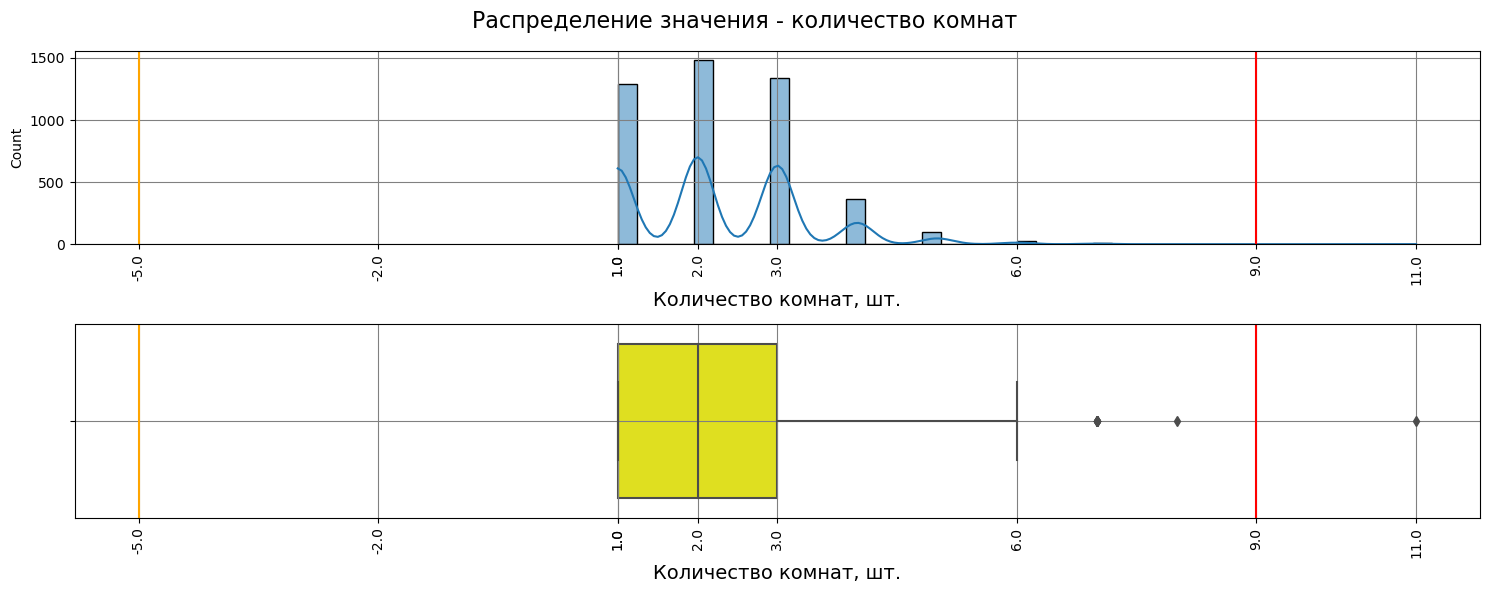

count    4614.000000
mean        2.270048
std         1.085897
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        11.000000
Name: rooms, dtype: float64


In [39]:
plotter(data = data,
        column = 'rooms', 
        title_plot = 'количество комнат', 
        xtitle = 'Количество комнат, шт.',
        limits = False,
       )

<div> 
<b>Вывод по графику:</b> <i>C комнатами вроде все хорошо, хотя 6 и  больше можно и удалить, чтобы сильно не выбивались.</i>
</div>

In [40]:
data = data.query('rooms < 6')

# Обработка, преобразование и категоризация данных

Здесь получаем следующие признаки:
- цена одного квадратного метра;
- день недели публикации объявления (0 — понедельник, 1 — вторник и так далее);
- месяц публикации объявления;
- год публикации объявления;
- тип этажа квартиры (значения — «первый», «последний», «другой»);
- расстояние до центра города в километрах.

In [41]:
# Расчет цены квадратного метра
data['price_of_metr'] = round(data['last_price']/data['total_area'],2)
data.sample(5)

,total_images,last_price,living_area,total_area,kitchen_area,floor,first_day_exposition,rooms,ceiling_height,floors_total,is_apartment,studio,open_plan,balcony,locality_type,locality_name,locality_full_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_of_metr
16986,19,14700000,104.80,174.50,15.10,4,2019-03-12,5,2.65,4,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,21638.0,3600.0,2,318.0,1,826.0,0,84240.69
2029,7,5999000,29.00,53.00,9.70,1,2016-10-31,2,2.65,3,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,27313.0,6016.0,1,592.0,1,931.0,663,113188.68
5463,1,6868120,18.95,51.64,18.34,4,2016-05-06,1,2.65,12,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,39946.0,10720.0,1,2102.0,3,303.0,59,133000.00
1846,17,15093000,25.44,66.20,13.70,2,2016-06-20,1,2.65,8,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,27102.0,7442.0,2,164.0,2,473.0,66,227990.94
2015,20,6375000,43.10,71.30,10.80,3,2017-11-12,3,2.65,12,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,36336.0,11535.0,1,550.0,1,643.0,156,89410.94


In [42]:
# Добавление столбцов с днем недели, месяцем и годом публикации объявления
data['day_of_week'] = data['first_day_exposition'].dt.day_name()
data['month'] = pd.DatetimeIndex(data['first_day_exposition']).month
data['year'] = pd.DatetimeIndex(data['first_day_exposition']).year
data.sample(5)

,total_images,last_price,living_area,total_area,kitchen_area,floor,first_day_exposition,rooms,ceiling_height,floors_total,is_apartment,studio,open_plan,balcony,locality_type,locality_name,locality_full_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_of_metr,day_of_week,month,year
22192,5,6120000,30.5,53.0,8.8,12,2019-01-09,2,2.50,12,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,50477.0,13252.0,2,220.0,1,1250.0,69,115471.70,Wednesday,1,2019
20121,1,9600000,40.2,85.4,23.1,4,2018-02-06,2,2.65,10,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,30894.0,4087.0,1,696.0,1,223.0,60,112412.18,Tuesday,2,2018
2976,12,3700000,19.0,37.0,9.0,2,2017-10-30,1,2.60,15,False,False,False,1,,Санкт-Петербург,Санкт-Петербург,13783.0,12580.0,2,616.0,1,974.0,7,100000.00,Monday,10,2017
13277,19,7300000,30.5,59.0,8.8,5,2019-02-22,2,3.20,5,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,19904.0,1579.0,3,441.0,3,157.0,5,123728.81,Friday,2,2019
17185,0,3980000,30.5,53.0,8.8,1,2015-12-08,2,2.65,5,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,20551.0,15352.0,3,90.0,2,561.0,447,75094.34,Tuesday,12,2015


In [43]:
# Категоризирую этажи
data['type_of_floor'] = data.apply(lambda x: type_of_floor(x.floor, x.floors_total), axis = 1)
data.head()

,total_images,last_price,living_area,total_area,kitchen_area,floor,first_day_exposition,rooms,ceiling_height,floors_total,is_apartment,studio,open_plan,balcony,locality_type,locality_name,locality_full_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_of_metr,day_of_week,month,year,type_of_floor
0,20,13000000,51.0,108.0,25.0,8,2019-03-07,3,2.70,16,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,0,120370.37,Thursday,3,2019,другой
2,10,5196000,34.3,56.0,8.3,4,2015-08-20,2,2.65,5,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558,92785.71,Thursday,8,2015,другой
3,0,64900000,45.0,159.0,9.5,9,2015-07-24,3,2.65,14,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424,408176.10,Friday,7,2015,другой
4,2,10000000,32.0,100.0,41.0,13,2018-06-19,2,3.03,14,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121,100000.00,Tuesday,6,2018,другой
10,5,5050000,20.3,39.6,8.5,3,2017-11-16,1,2.67,12,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,38357.0,13878.0,1,310.0,2,553.0,137,127525.25,Thursday,11,2017,другой


In [44]:
# Добавляю столбец с расстоянием до центра в километрах
data['cityCenters_nearest_KM'] = data['cityCenters_nearest']/1000
data['cityCenters_nearest_KM'] = data['cityCenters_nearest_KM'].astype(int)
data.sample(10)

,total_images,last_price,living_area,total_area,kitchen_area,floor,first_day_exposition,rooms,ceiling_height,floors_total,is_apartment,studio,open_plan,balcony,locality_type,locality_name,locality_full_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_of_metr,day_of_week,month,year,type_of_floor,cityCenters_nearest_KM
8069,6,6500000,23.5,57.0,11.1,6,2018-10-05,2,3.07,9,False,False,False,1,,Санкт-Петербург,Санкт-Петербург,9522.0,13738.0,2,636.0,1,565.0,159,114035.09,Friday,10,2018,другой,13
531,6,4300000,30.5,50.0,7.0,3,2016-11-24,2,2.65,12,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,51149.0,13478.0,3,558.0,1,384.0,193,86000.00,Thursday,11,2016,другой,13
7775,15,4150000,20.5,40.0,10.8,9,2017-12-19,1,2.65,20,False,False,False,1,,Санкт-Петербург,Санкт-Петербург,30230.0,11360.0,1,413.0,1,925.0,55,103750.00,Tuesday,12,2017,другой,11
1876,12,11490000,45.4,74.0,9.8,5,2016-08-31,3,2.70,5,False,False,False,1,,Санкт-Петербург,Санкт-Петербург,20717.0,936.0,3,333.0,2,29.0,469,155270.27,Wednesday,8,2016,последний,0
21895,20,7380000,32.7,58.5,10.4,9,2018-07-20,2,2.55,10,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,13214.0,10006.0,1,526.0,1,396.0,4,126153.85,Friday,7,2018,другой,10
15004,0,35000000,80.0,90.0,10.0,6,2018-08-22,3,2.65,7,False,False,False,1,,Санкт-Петербург,Санкт-Петербург,25393.0,4096.0,1,247.0,1,656.0,16,388888.89,Wednesday,8,2018,другой,4
15596,2,3500000,18.2,43.9,11.6,1,2018-10-19,1,2.70,16,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,41,79726.65,Friday,10,2018,первый,16
15755,10,8200000,25.0,71.0,30.0,5,2018-07-26,2,2.65,5,False,False,False,0,,Пушкин,Пушкин,19841.0,30183.0,1,531.0,3,330.0,113,115492.96,Thursday,7,2018,последний,30
2137,7,8700000,69.8,116.0,10.6,8,2016-03-11,5,2.60,9,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,13772.0,13667.0,1,238.0,1,272.0,211,75000.00,Friday,3,2016,другой,13
13517,7,6800000,13.0,36.5,12.0,7,2018-02-09,1,3.10,11,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,29189.0,5838.0,1,131.0,2,659.0,276,186301.37,Friday,2,2018,другой,5


# Исследовательский анализ данных

## Изучение параметров объектов:
- общая площадь;
- жилая площадь;
- площадь кухни;
- цена объекта;
- количество комнат;
- высота потолков;
- этаж квартиры;
- тип этажа квартиры («первый», «последний», «другой»);
- общее количество этажей в доме;
- расстояние до центра города в метрах;
- расстояние до ближайшего аэропорта;
- расстояние до ближайшего парка;
- день и месяц публикации объявления.

In [45]:
data.columns

Index(['total_images', 'last_price', 'living_area', 'total_area',
       'kitchen_area', 'floor', 'first_day_exposition', 'rooms',
       'ceiling_height', 'floors_total', 'is_apartment', 'studio', 'open_plan',
       'balcony', 'locality_type', 'locality_name', 'locality_full_name',
       'airports_nearest', 'cityCenters_nearest', 'parks_around3000',
       'parks_nearest', 'ponds_around3000', 'ponds_nearest', 'days_exposition',
       'price_of_metr', 'day_of_week', 'month', 'year', 'type_of_floor',
       'cityCenters_nearest_KM'],
      dtype='object')

In [46]:
data.select_dtypes(['float', 'int']).columns

Index(['total_images', 'last_price', 'living_area', 'total_area',
       'kitchen_area', 'floor', 'rooms', 'ceiling_height', 'floors_total',
       'balcony', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'price_of_metr', 'month', 'year',
       'cityCenters_nearest_KM'],
      dtype='object')

## Анализ характеристики "цена продажи"

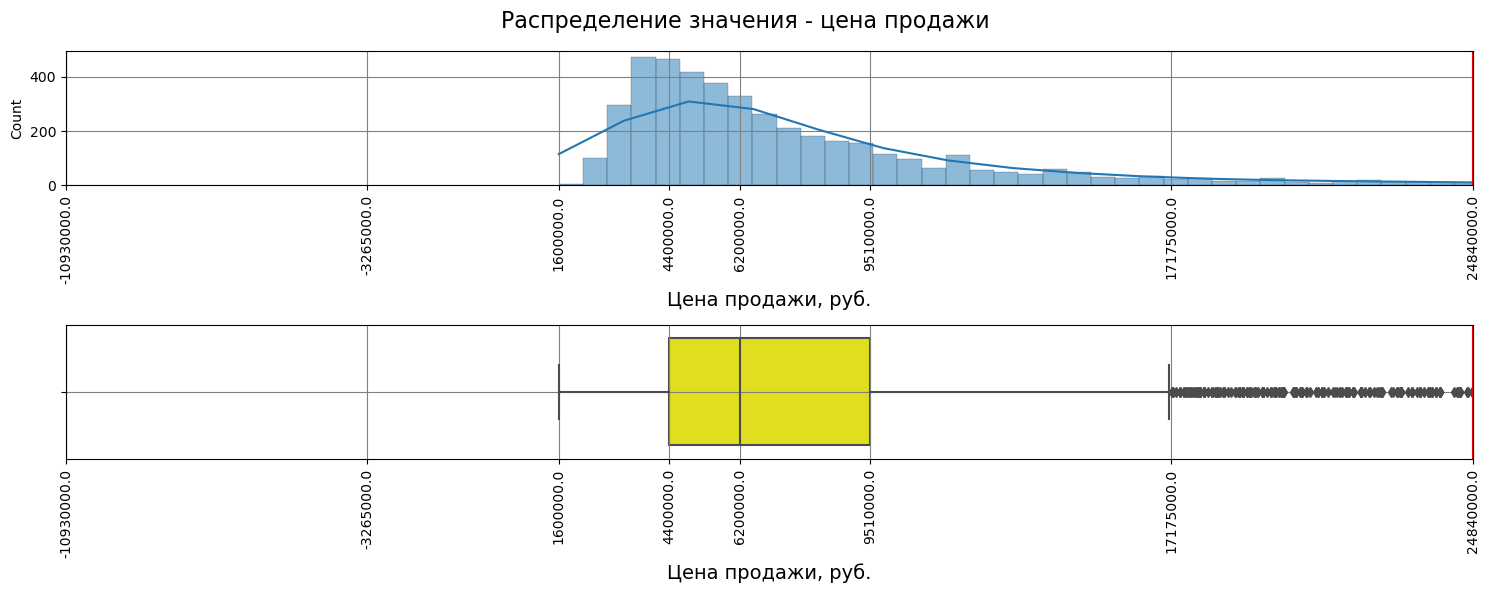

count    4.575000e+03
mean     8.815841e+06
std      1.063719e+07
min      1.600000e+06
25%      4.400000e+06
50%      6.200000e+06
75%      9.510000e+06
max      3.300000e+08
Name: last_price, dtype: float64


In [47]:
plotter(data = data,
        column = 'last_price', 
        title_plot = 'цена продажи', 
        xtitle = 'Цена продажи, руб.',
        limits = True,
       )

<div>
<b>Вывод по графику:</b> <i>больше всего квартир продается примерно за 4 000 000 руб. Форма распределения близка к нормальному.</i>
</div>

## Анализ характеристики "жилая площадь"

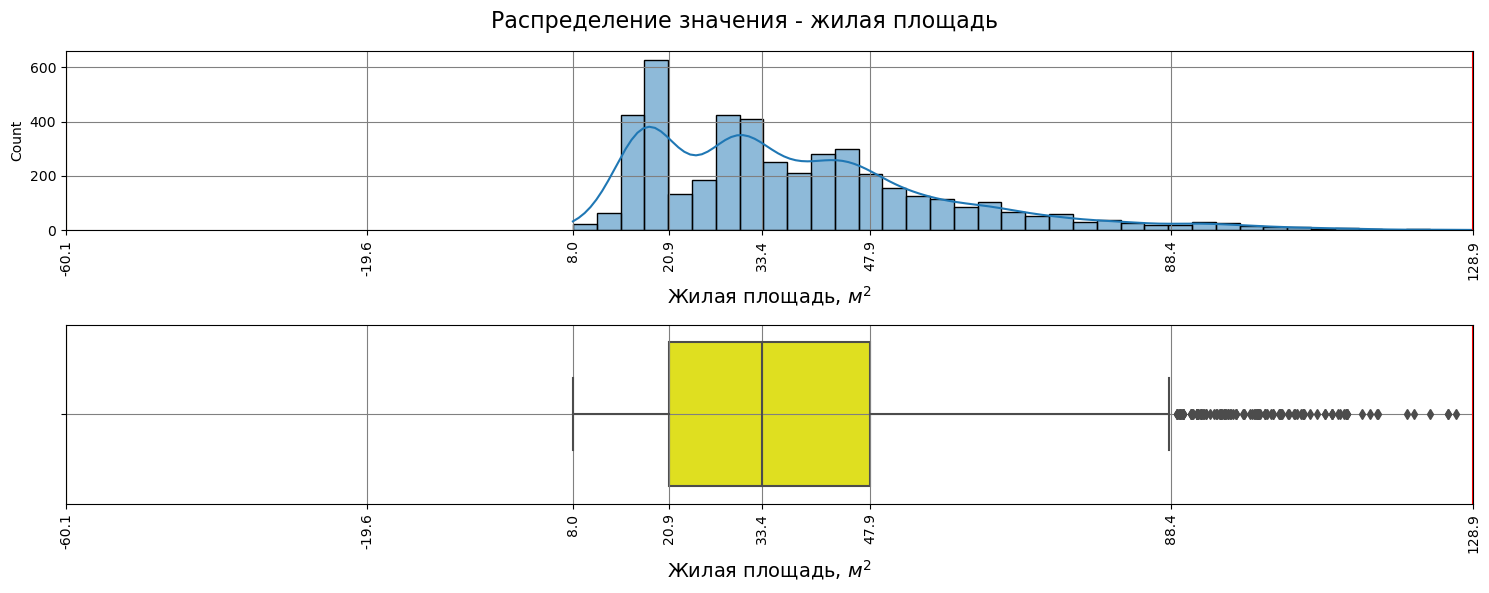

count    4575.000000
mean       38.135918
std        20.133798
min         8.000000
25%        20.900000
50%        33.400000
75%        47.900000
max       164.700000
Name: living_area, dtype: float64


In [48]:
plotter(data = data,
        column = 'living_area', 
        title_plot = 'жилая площадь', 
        xtitle = 'Жилая площадь, $м^2$',
        limits = True,
       )

<div>
<b>Вывод по графику:</b> <i>распределение имеет две ярко выраженные моды, это квартиры с <b>жилой</b> площадью около 16 кв.м. и 30 кв.м. Скорее всего это однокомнатные и двухкомнатные. Третья мода менее всего выражена, квартиры с <b>жилой</b> площадью 43-44 кв.м.</i>
</div>

## Анализ характеристики "площадь кухни"

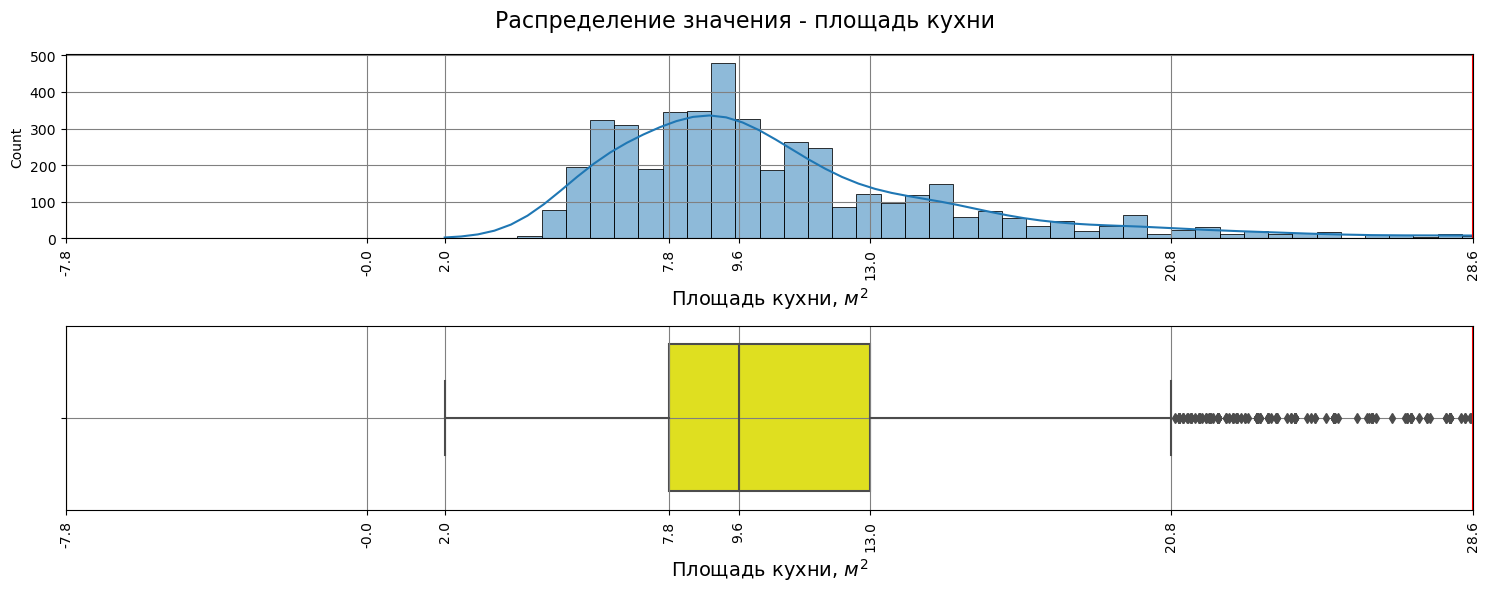

count    4575.000000
mean       11.348855
std         6.441667
min         2.000000
25%         7.800000
50%         9.600000
75%        13.000000
max        87.200000
Name: kitchen_area, dtype: float64


In [49]:
plotter(data = data,
        column = 'kitchen_area', 
        title_plot = 'площадь кухни', 
        xtitle = 'Площадь кухни, $м^2$',
        limits = True,
       )

<div>
<b>Вывод по графику:</b> <i>наиболее распространены квартиры с площадью кухни в районе 9-10 кв.м. Форма распределения близка к нормальной.</i>
</div>    

## Анализ характеристики "общая площадь"

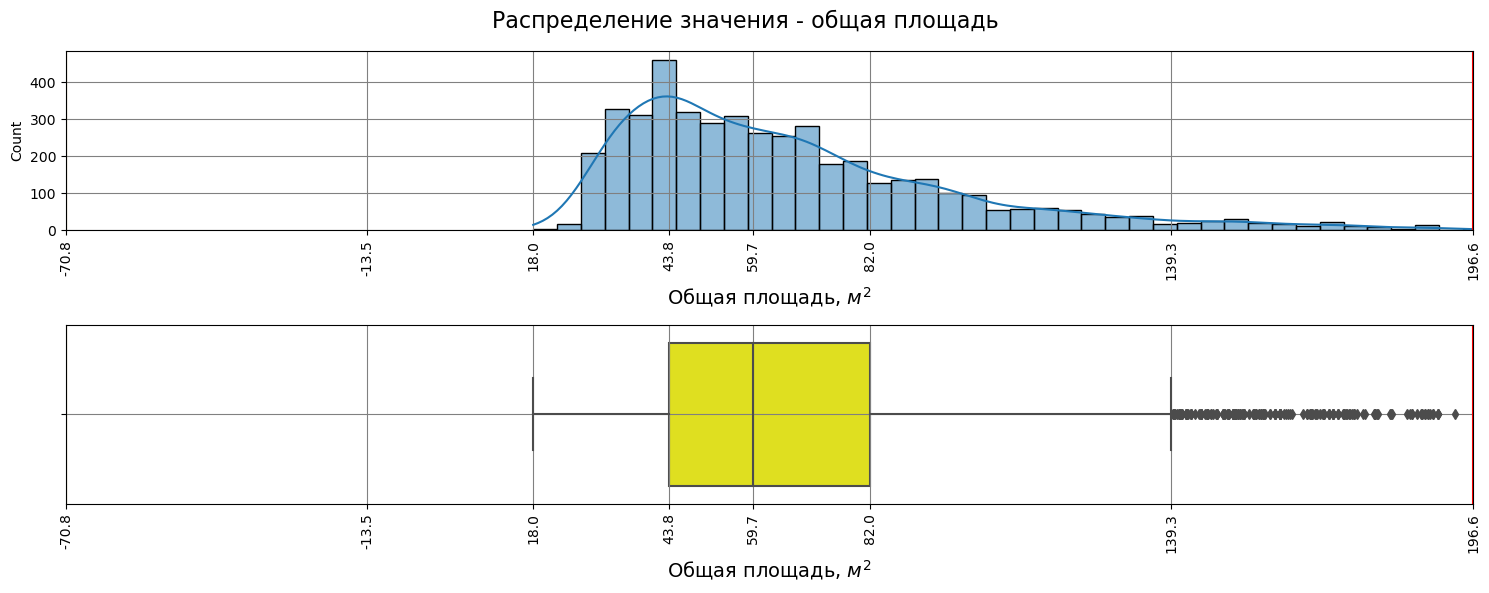

count    4575.000000
mean       67.253985
std        31.916266
min        18.000000
25%        43.800000
50%        59.700000
75%        82.000000
max       199.200000
Name: total_area, dtype: float64


In [50]:
plotter(data = data,
        column = 'total_area', 
        title_plot = 'общая площадь', 
        xtitle = 'Общая площадь, $м^2$',
        limits = True,
       )

<div>
<b>Вывод по графику:</b> <i>больше всего квартир <b>общей</b> площадью от 42 до 46 кв.м., на втором месте квартиры площадью от 33 до 37 кв.м., на третьем - от 56 до 60 кв.м.</i>
</div>    

## Анализ характеристики "этаж"

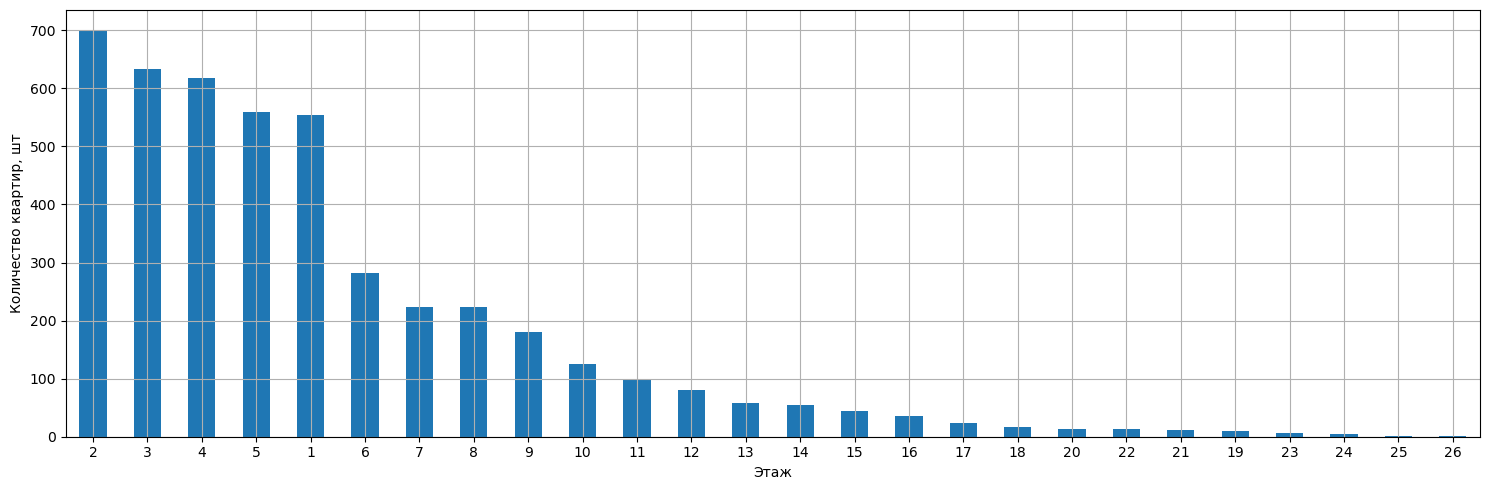

count    4575.000000
mean        5.218579
std         4.040390
min         1.000000
25%         2.000000
50%         4.000000
75%         7.000000
max        26.000000
Name: floor, dtype: float64

In [51]:
# Анализ 'floor'
ax = data.groupby('floor')['floor'].count().sort_values(ascending = False).plot(
        x = data.groupby('floor')['floor'].count().index,
        y = data.groupby('floor')['floor'].count(), 
        kind = 'bar', 
        grid = True, 
        figsize = (15,5),
        rot = 0,
    )
ax.set_ylabel('Количество квартир, шт')
ax.set_xlabel('Этаж')
plt.tight_layout()
plt.show()
data.floor.describe()

<div>
<b>Вывод по графику:</b> <i>больше всего квартир продают на 2 этаже, на втором месте - 3 этаж, на третьем и четвертом - 1 и 4 этажи.</i>
</div>    

## Анализ характеристики "количество комнат"

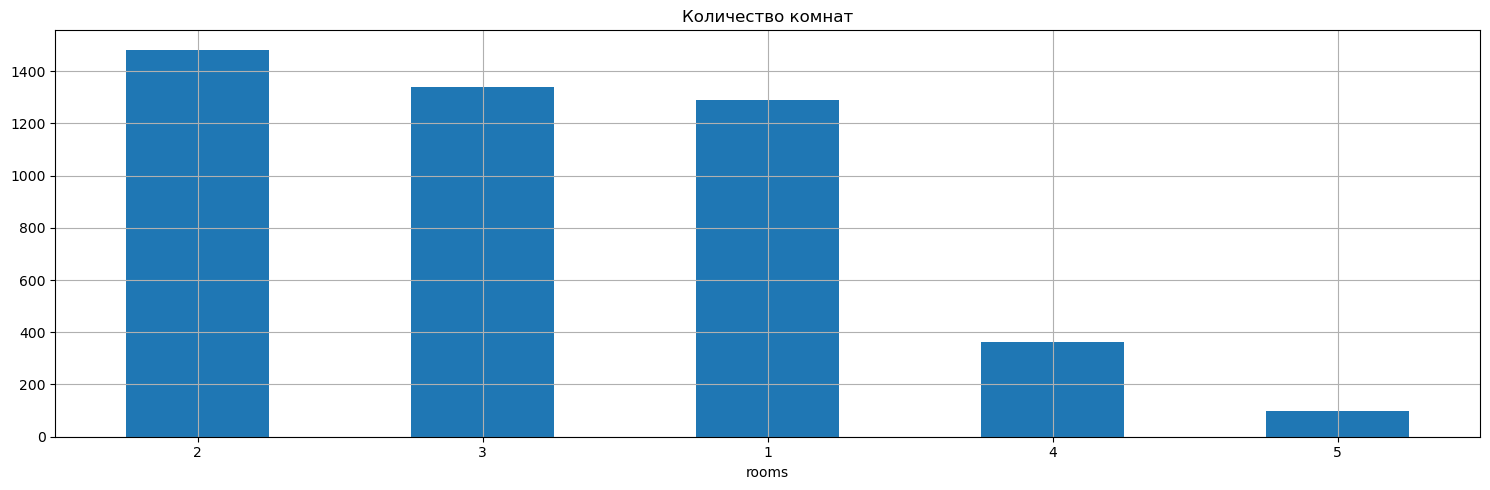

count    4575.000000
mean        2.234536
std         1.016409
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         5.000000
Name: rooms, dtype: float64

In [52]:
data.groupby('rooms')['rooms'].count().sort_values(ascending = False).plot(
    x = data.groupby('rooms')['rooms'].count().index,
    y = data.groupby('rooms')['rooms'].count(), 
    kind = 'bar', 
    grid = True, 
    title = "Количество комнат",
    rot = 0,
    figsize = (15,5),
)
plt.tight_layout()
plt.show()
data.rooms.describe()

<div>
<b>Вывод по графику:</b> <i>на рынке недвижимости очень много однушек и двушек (практически одинаковое количество), при этом предложений с трехкомнатными квартирами меньше почти на 1000.</i>
</div>    

## Анализ характеристики "высота потолков"

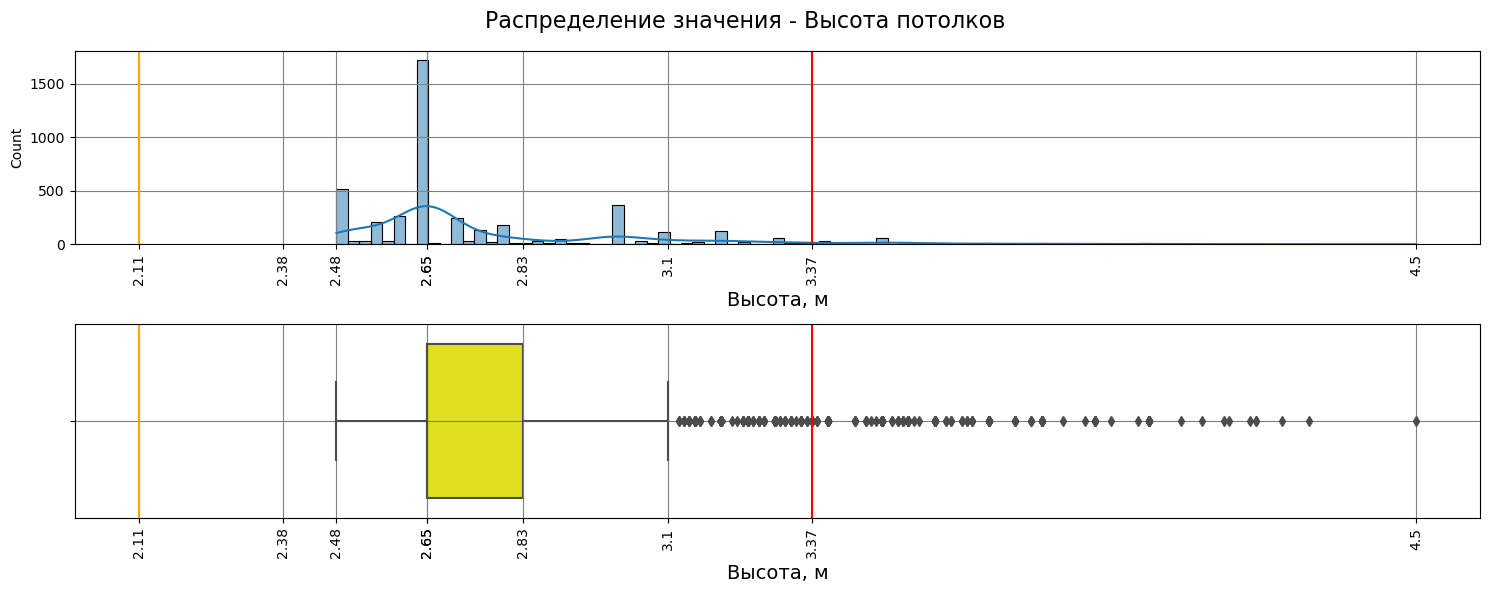

count    4575.000000
mean        2.768144
std         0.278494
min         2.480000
25%         2.650000
50%         2.650000
75%         2.830000
max         4.500000
Name: ceiling_height, dtype: float64


In [53]:
plotter(data = data, 
        column = 'ceiling_height', 
        title_plot = 'Высота потолков', 
        xtitle = 'Высота, м',
        limits = False,
       )

<div>
<b>Вывод по графику:</b> <i>самое большое количество квартир с высотой потолков в районе 2,6 м, на втором месте, с отставанием в 6 тысяч предложений, с высотой 2,5 м.</i>
</div>    

## Анализ характеристики "количество этажей в доме"

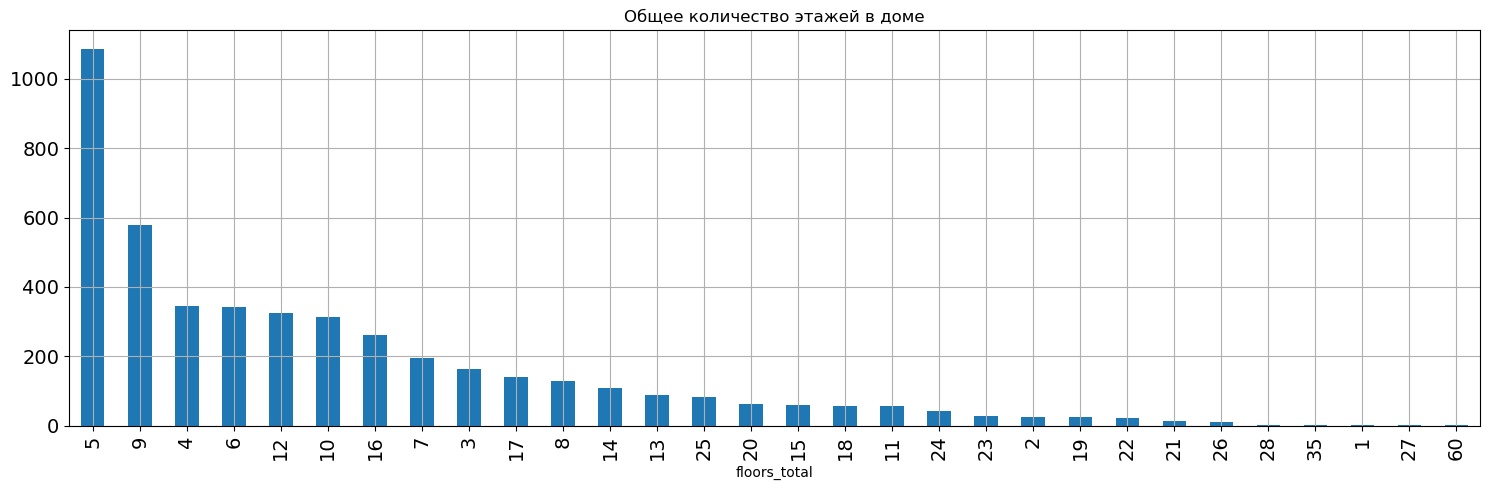

count    4575.000000
mean        9.328743
std         5.412935
min         1.000000
25%         5.000000
50%         9.000000
75%        12.000000
max        60.000000
Name: floors_total, dtype: float64

In [54]:
# Анализ 'floors_total'
data.groupby('floors_total')['floors_total'].count().sort_values(ascending = False).plot(
    x = data.groupby('floors_total')['floors_total'].count().index,
    y = data.groupby('floors_total')['floors_total'].count(), 
    kind = 'bar', 
    grid = True, 
    title = "Общее количество этажей в доме",
    figsize = (15,5),
    fontsize = 14,
)
plt.tight_layout()
plt.show()
data.floors_total.describe()

<div>
<b>Вывод по графику:</b> <i>больше всего квартир находятся в пятиэтажках, на втором месте - девятиэтажки, на третьем 12-ти и 16-ти этажные дома.</i>
</div>    

## Анализ характеристики "расстояние для ближайшего аэропорта"

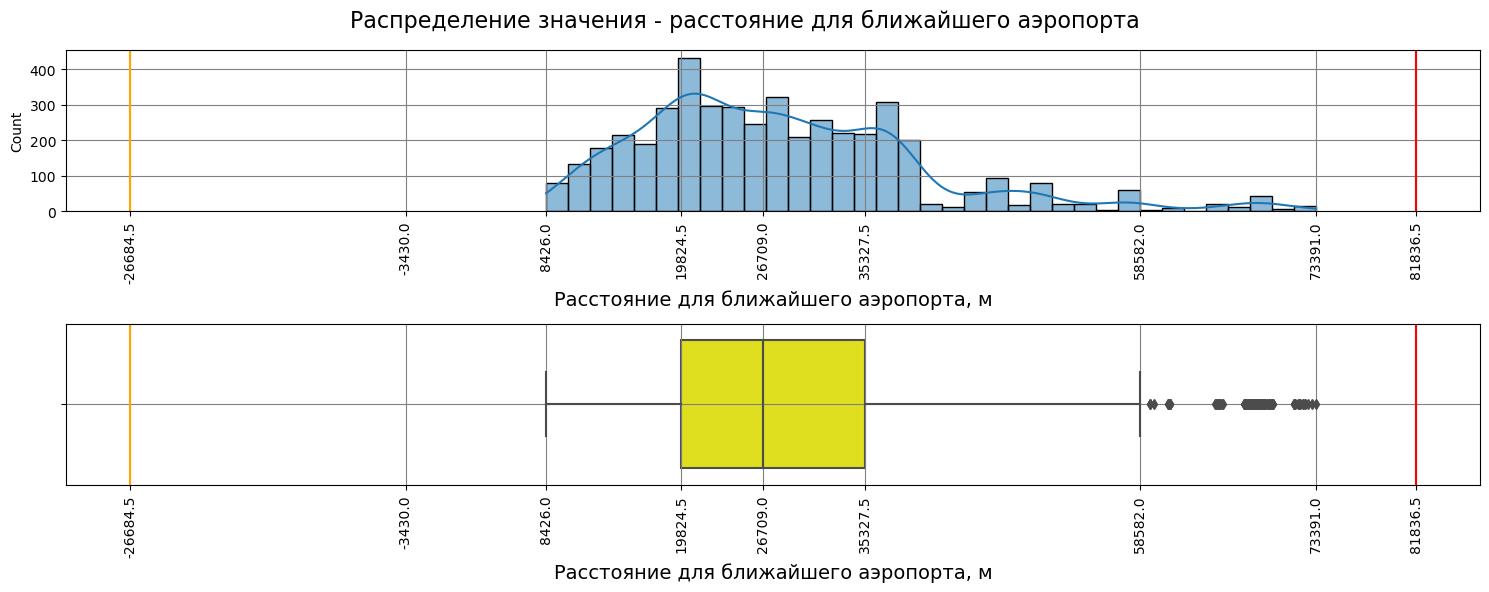

count     4575.000000
mean     28202.787541
std      11941.371645
min       8426.000000
25%      19824.500000
50%      26709.000000
75%      35327.500000
max      73391.000000
Name: airports_nearest, dtype: float64


In [55]:
plotter(data = data,
        column = 'airports_nearest', 
        title_plot = 'расстояние для ближайшего аэропорта', 
        xtitle = "Расстояние для ближайшего аэропорта, м",
        limits = False,
       )

<div>
<b>Вывод по графику:</b> <i>основная масса квартир находится на расстоянии 21 - 34 км от аэропорта.</i>
</div>

## Анализ характеристики "расстояние до центра города"

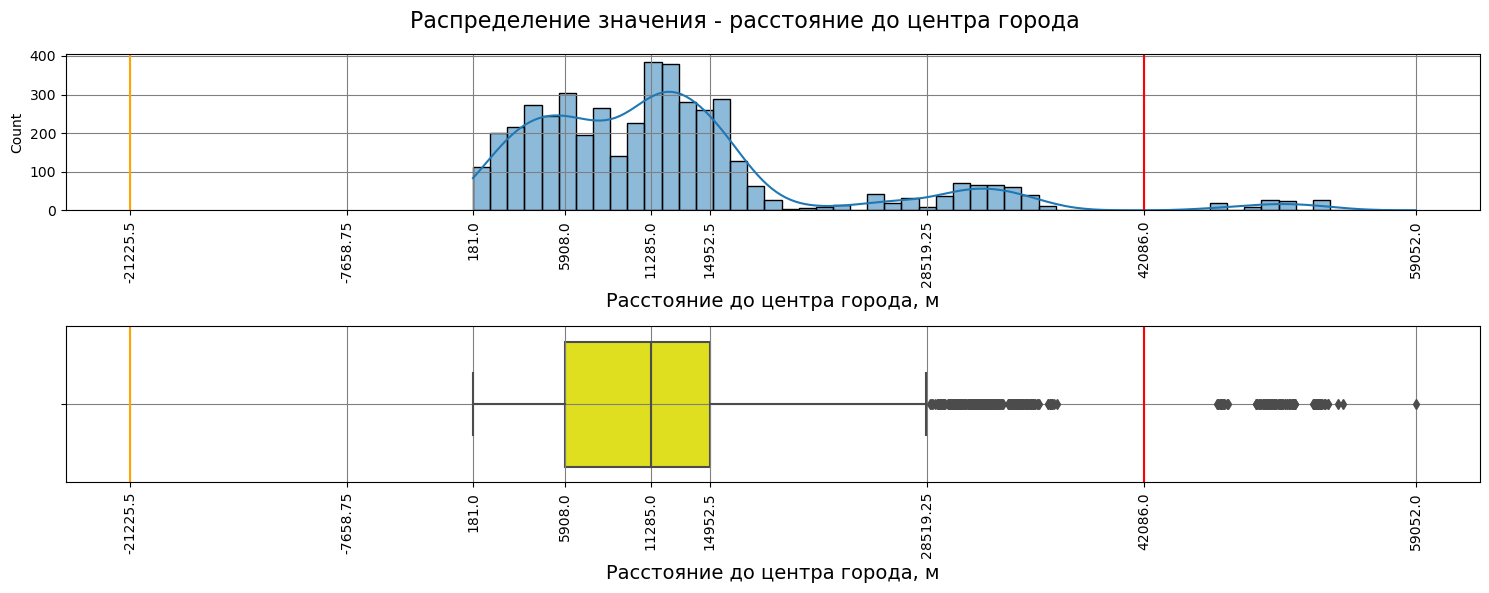

count     4575.000000
mean     12627.676721
std       9932.363659
min        181.000000
25%       5908.000000
50%      11285.000000
75%      14952.500000
max      59052.000000
Name: cityCenters_nearest, dtype: float64


In [56]:
plotter(data = data,
        column = 'cityCenters_nearest', 
        title_plot = 'расстояние до центра города', 
        xtitle = "Расстояние до центра города, м",
        limits = False,
       )

**Вывод по графику:** *Больше всего квартир находятся в центре населенного пункта. но и не мало квартир на расстоянии от 10 до 17 км от центра.*

## Анализ характеристики "расстояние до ближайшего парка"

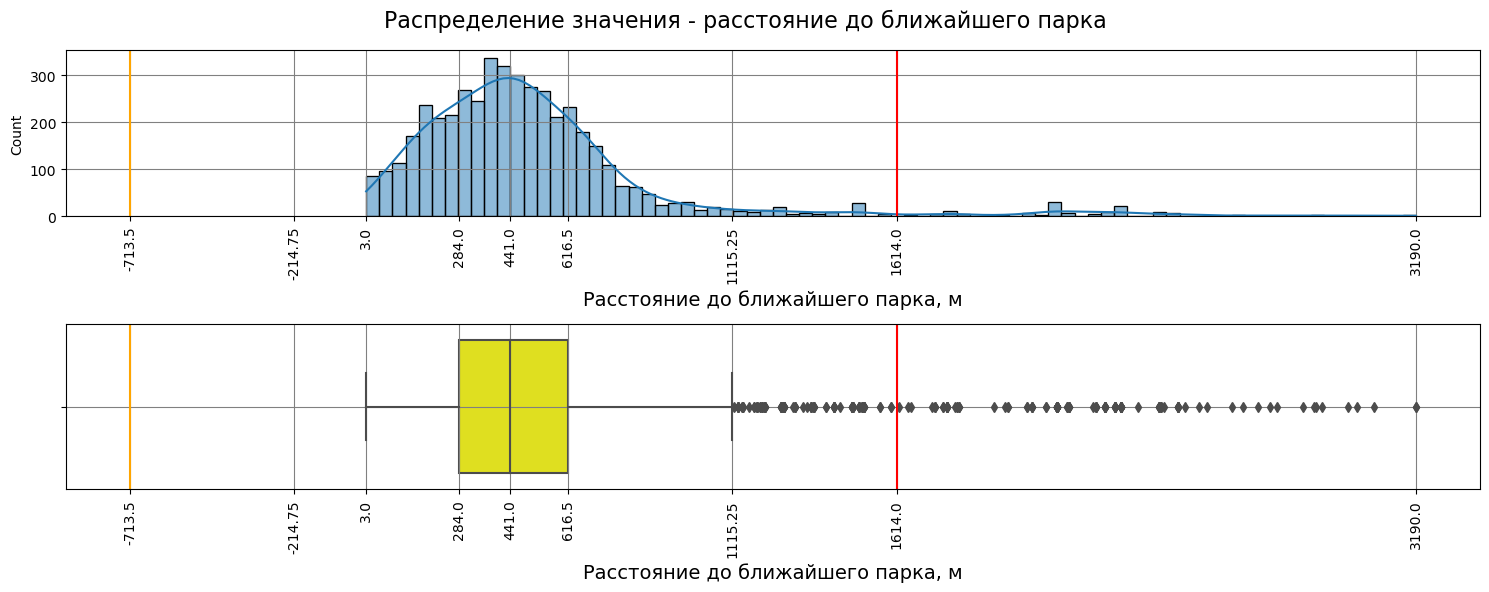

count    4575.000000
mean      509.826448
std       397.821792
min         3.000000
25%       284.000000
50%       441.000000
75%       616.500000
max      3190.000000
Name: parks_nearest, dtype: float64


In [57]:
plotter(data = data,
        column = 'parks_nearest', 
        title_plot = 'расстояние до ближайшего парка', 
        xtitle = "Расстояние до ближайшего парка, м",
        limits = False,
       )

**Вывод по графику:** *В основном квартиры находятся на расстоянии 450 м. от ближайшего парка.*

## Анализ характеристики "день недели"

In [58]:
data.groupby('day_of_week')['day_of_week'].count()

day_of_week
Friday       756
Monday       688
Saturday     373
Sunday       311
Thursday     837
Tuesday      829
Wednesday    781
Name: day_of_week, dtype: int64

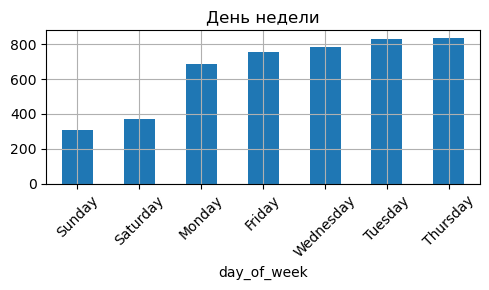

count         4575
unique           7
top       Thursday
freq           837
Name: day_of_week, dtype: object

In [59]:
data.groupby('day_of_week')['day_of_week'].count().sort_values()\
              .plot(x = data.groupby('day_of_week')['day_of_week'].count().index,
                    y = data.groupby('day_of_week')['day_of_week'].count(),
                    kind = 'bar', 
                    grid = True, 
                    title = "День недели",
                    figsize = (5,3),
                    rot = 45,
                   )
plt.tight_layout()
plt.show()
data.day_of_week.describe()

**Вывод по графику:** *Чаще всего объявления размещают на буднях, особенно в четверг. Наиболее редко - на выходных, особенно в воскресенье.*

## Анализ характеристики "месяц размещения объявления"

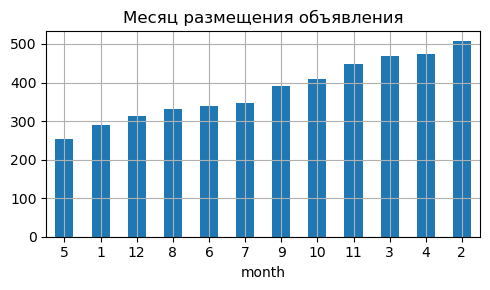

In [60]:
data.groupby('month')['month'].count().sort_values().plot(
    x = data.groupby('month')['month'].count().index,
    y = data.groupby('month')['month'].count(),
    kind = 'bar', 
    grid = True, 
    title = "Месяц размещения объявления",
    rot = 0,
    figsize = (5,3),
)
plt.tight_layout()
plt.show()

**Вывод по графику:** *Чаще всего объявления размещают в феврале и в апреле, а реже всего в мае.*

## Анализ характеристики "длительность размещения объявления"

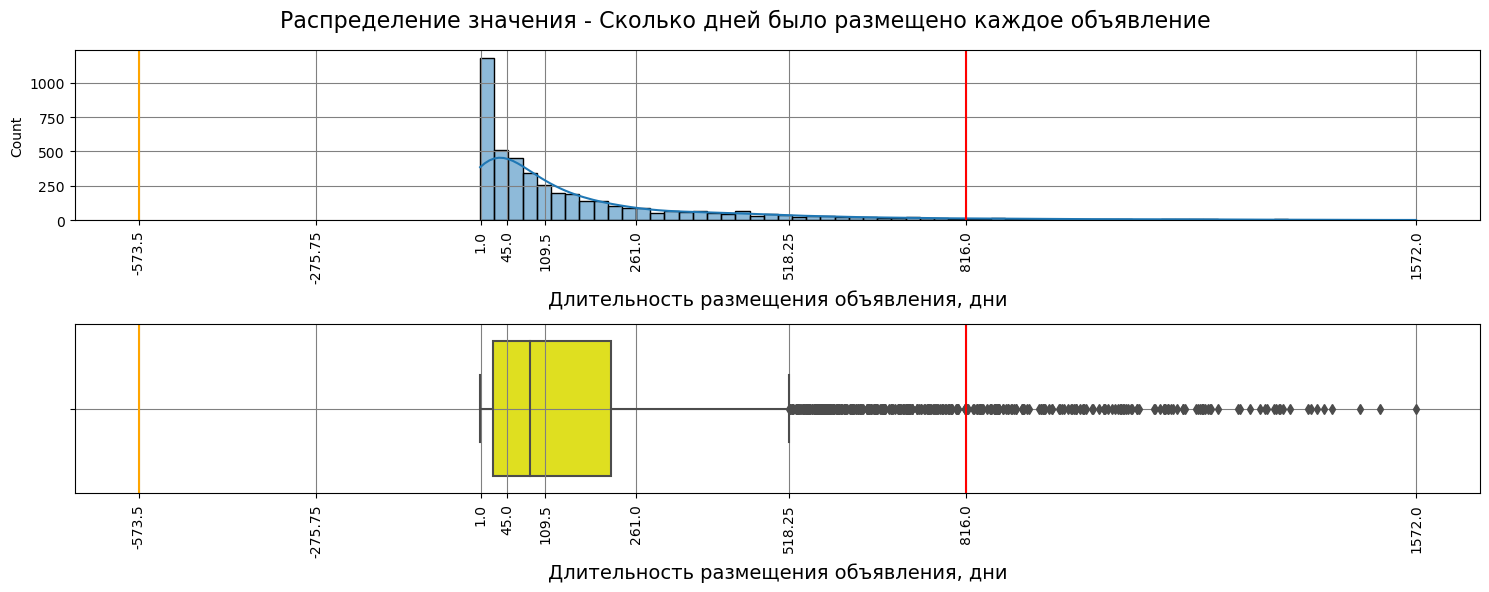

count    4575.000000
mean      172.841749
std       234.446133
min         0.000000
25%        22.000000
50%        84.000000
75%       220.500000
max      1572.000000
Name: days_exposition, dtype: float64


In [61]:
plotter(data = data,
        column = 'days_exposition', 
        title_plot = 'Cколько дней было размещено каждое объявление', 
        xtitle = "Длительность размещения объявления, дни",
        limits = False,
       )

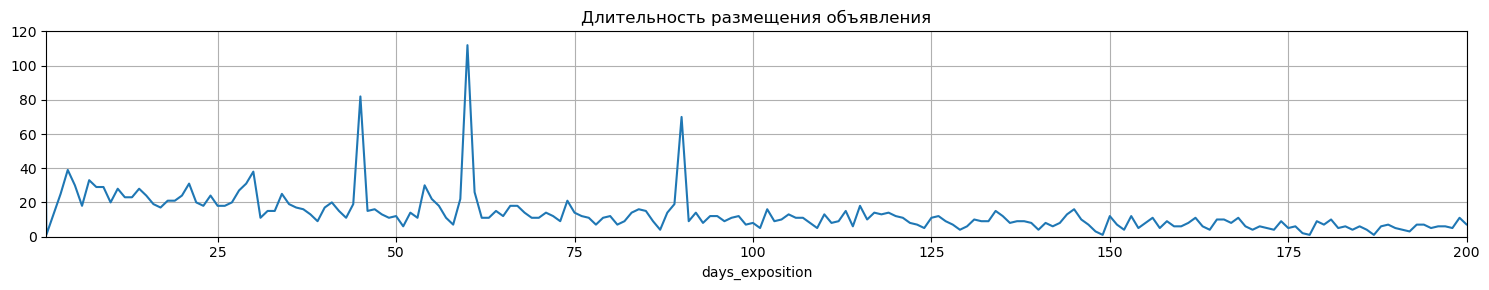

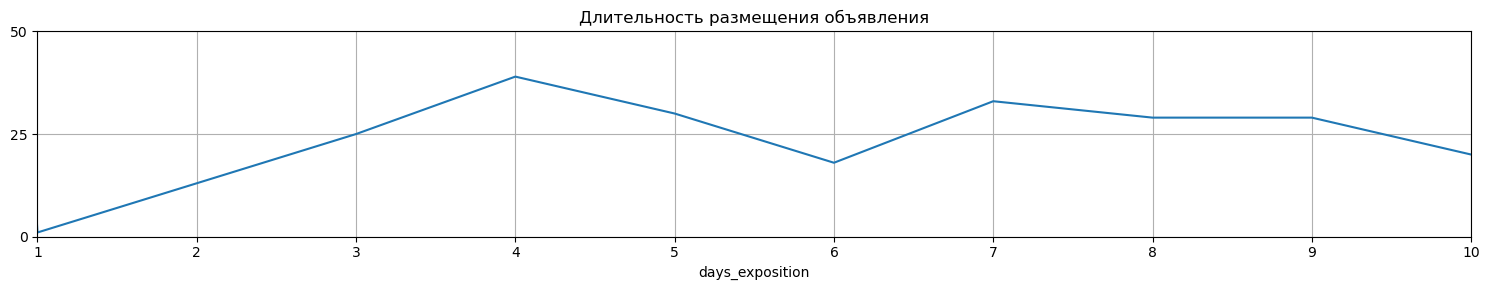

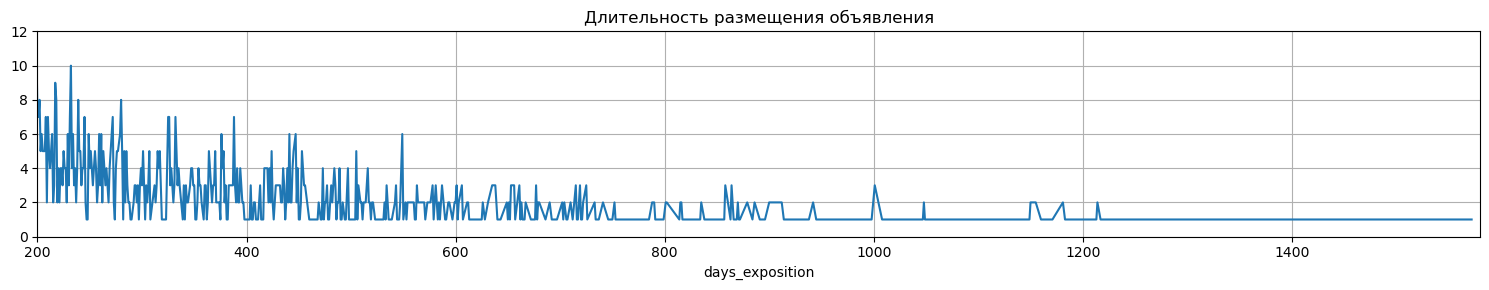

In [62]:
data.groupby('days_exposition')['days_exposition'].count().plot(
    x = data.groupby('days_exposition')['days_exposition'].count().index,
    y = data.groupby('days_exposition')['days_exposition'].count(),
    kind = 'line', 
    grid = True, 
    title = "Длительность размещения объявления",
    rot = 0,
    figsize = (15, 3), 
    xlim = (1,200),
    ylim = (0,120),
    #xticks = range(0,200,5),
)
plt.tight_layout()
plt.show()
# Изучение быстрых продаж
data.groupby('days_exposition')['days_exposition'].count().plot(
    x = data.groupby('days_exposition')['days_exposition'].count().index,
    y = data.groupby('days_exposition')['days_exposition'].count(),
    kind = 'line', 
    grid = True, 
    title = "Длительность размещения объявления",
    rot = 0,
    figsize = (15, 3), 
    xlim = (1,10),
    ylim = (0,50),
    xticks = range(0,200,1),
    yticks = range(0,250,25),
)
plt.tight_layout()
plt.show()
# Изучение медленных продаж
data.groupby('days_exposition')['days_exposition'].count().plot(
    x = data.groupby('days_exposition')['days_exposition'].count().index,
    y = data.groupby('days_exposition')['days_exposition'].count(),
    kind = 'line', 
    grid = True, 
    title = "Длительность размещения объявления",
    rot = 0,
    figsize = (15, 3), 
    xlim = (200,1580),
    ylim = (0,12),
    #xticks = range(0,200,1),
    #yticks = range(0,250,25),
)
plt.tight_layout()
plt.show()

In [63]:
# Подсчет количества объявлений, срок размещения которых менее 10 дней
data.query('days_exposition < 10').days_exposition.count()

863

In [64]:
# Подсчет количества объявлений, срок размещения которых более 200 дней
data.query('days_exposition > 200').days_exposition.count()

1249

***Вывод по графикам:*** *В подавляющем числе случаев квартиры продаются менее чем за 10 дней (что странно, но так гласит верхний график), но далее есть пик - 45 дней. Возможно, это максимальный срок размещения объявления. Следующий пик в районе 57 дней. В общем и целом квартиры продаются довольно быстро, но есть и такие, срок продажи которых достигает нескольких лет.*

На графиках также прослеживается пик на 7 днях, т.е. такие продажи буду считать аномально быстрыми, а объявления, размещенные более 200 дней - медленными. При этом и медленных, и быстрых продаж примерно по 25 % от общего числа объявлений.

## Анализ зависимости цены квартиры от жилой площади

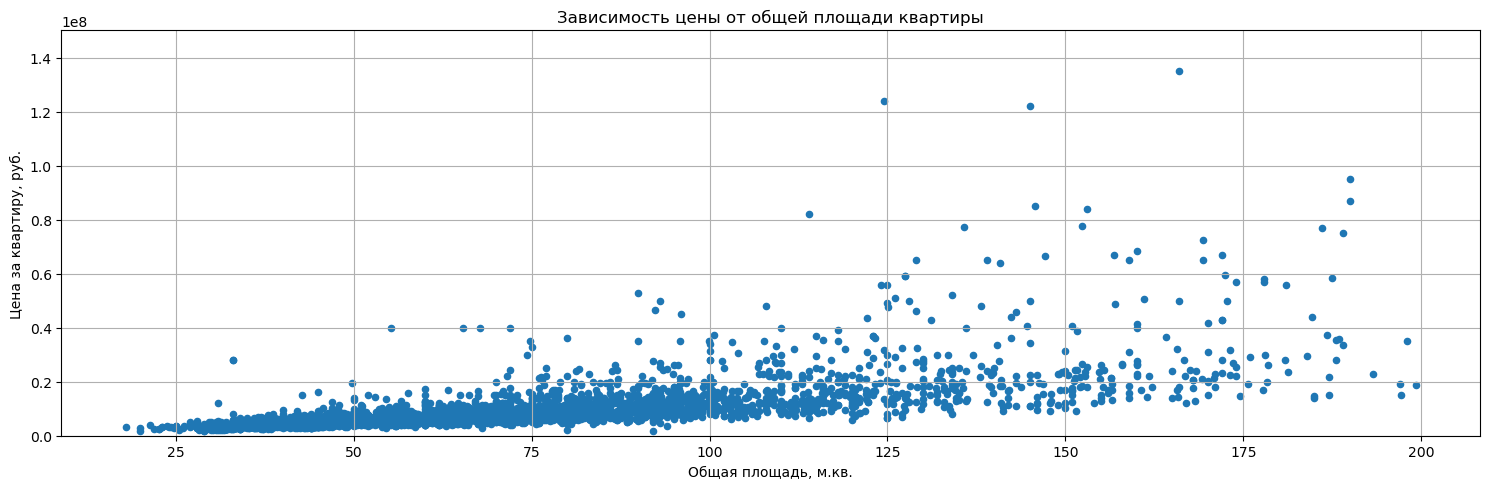

In [65]:
data.plot(
    x = 'total_area',
    xlabel = 'Общая площадь, м.кв.',
    y = 'last_price',
    ylabel = 'Цена за квартиру, руб.',
    kind = 'scatter', 
    grid = True, 
    figsize = (15,5),
    title = "Зависимость цены от общей площади квартиры",
    ylim = (0,15e7),
)
plt.tight_layout()
plt.show()

In [66]:
data['total_area'].corr(data['last_price'])

0.604842372756595

***Вывод по графику:*** *из графика видна неярко выраженная прямая зависимость цены от общей площади квартиры. Это подтверждает и коэффициент корреляции Пирсона, расчитанный выше.*

## Анализ зависимости цены квартиры от жилой площади

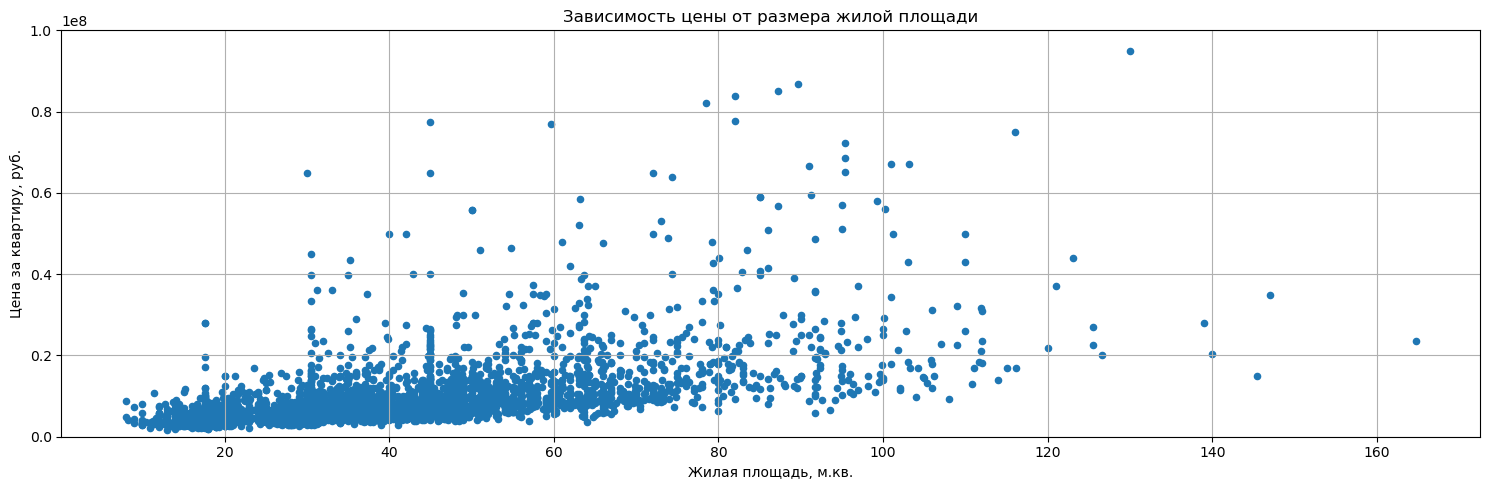

In [67]:
data.plot(x = 'living_area',
          xlabel = 'Жилая площадь, м.кв.',
          y = 'last_price',
          ylabel = 'Цена за квартиру, руб.',
          kind = 'scatter', 
          grid = True, 
          figsize = (15,5),
          title = "Зависимость цены от размера жилой площади",
          ylim = (0,1e8),
         )
plt.tight_layout()
plt.show()

In [68]:
data['living_area'].corr(data['last_price'])

0.4825506986060482

***Вывод по графику:*** *из графика видна слабая прямая зависимость цены от жилой площади квартиры.*

## Анализ зависимости цены квартиры от площади кухни

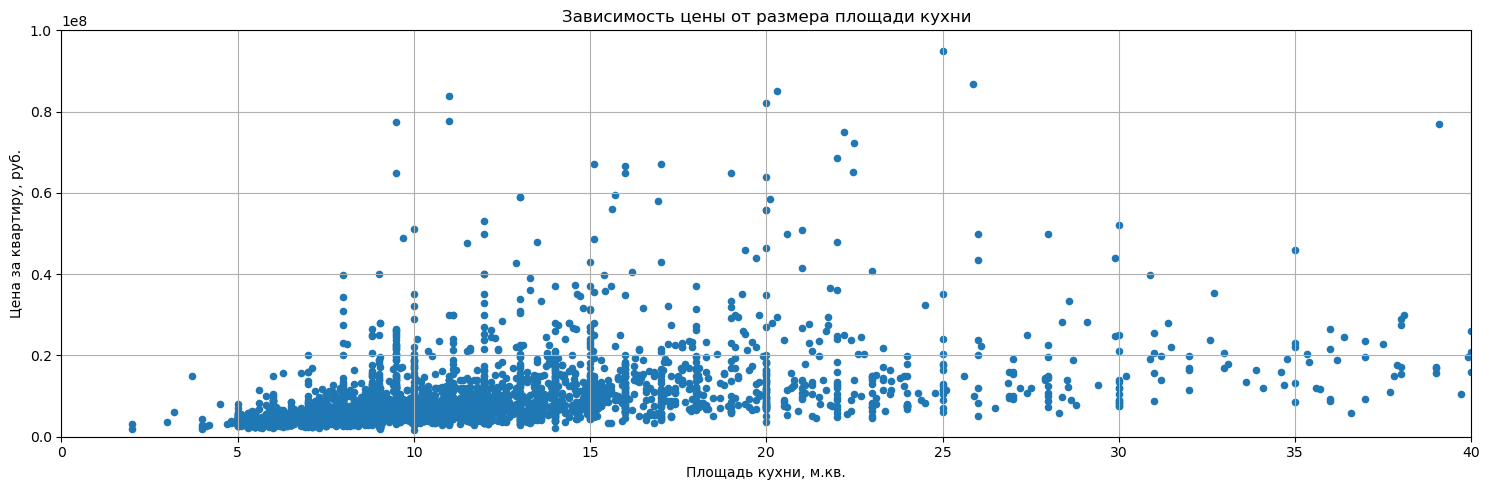

In [69]:
data.plot(
    x = 'kitchen_area',
    xlabel = 'Площадь кухни, м.кв.',
    y = 'last_price',
    ylabel = 'Цена за квартиру, руб.',
    kind = 'scatter', 
    grid = True, 
    figsize = (15,5),
    title = "Зависимость цены от размера площади кухни",
    xlim = (0,40),
    ylim = (0,1e8),
)
plt.tight_layout()
plt.show()

In [70]:
data['kitchen_area'].corr(data['last_price'])

0.46150772073705204

***Вывод по графику:*** *видна слабая зависимость цены квартиры от площади кухни.*

## Анализ зависимости цены квартиры от количества комнат

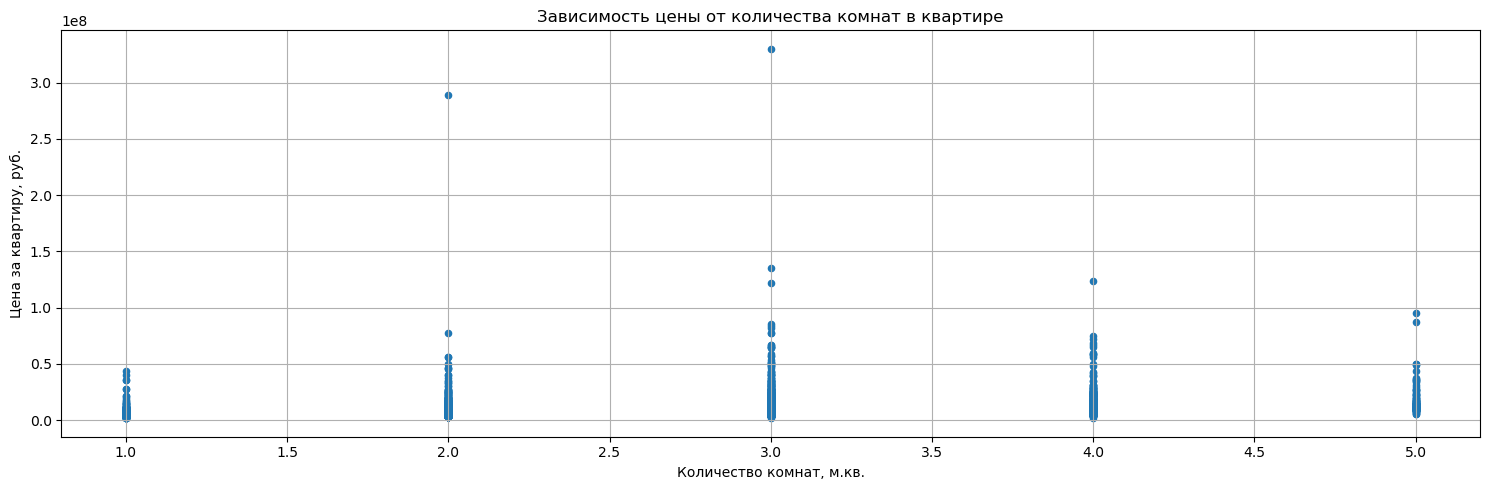

In [71]:
data.plot(
    x = 'rooms',
    xlabel = 'Количество комнат, м.кв.',
    y = 'last_price',
    ylabel = 'Цена за квартиру, руб.',
    kind = 'scatter', 
    grid = True, 
    figsize = (15,5),
    title = "Зависимость цены от количества комнат в квартире",
)
plt.tight_layout()
plt.show()

In [72]:
data['rooms'].corr(data['last_price'])

0.3293103740030565

***Вывод по графику:*** *самая высокая цена на трех- и четырехкомнатные квартиры, а самая низкая - на однокомнатные.*

## Анализ зависимости цены квартиры от категории этажа (первый, последний, другой)

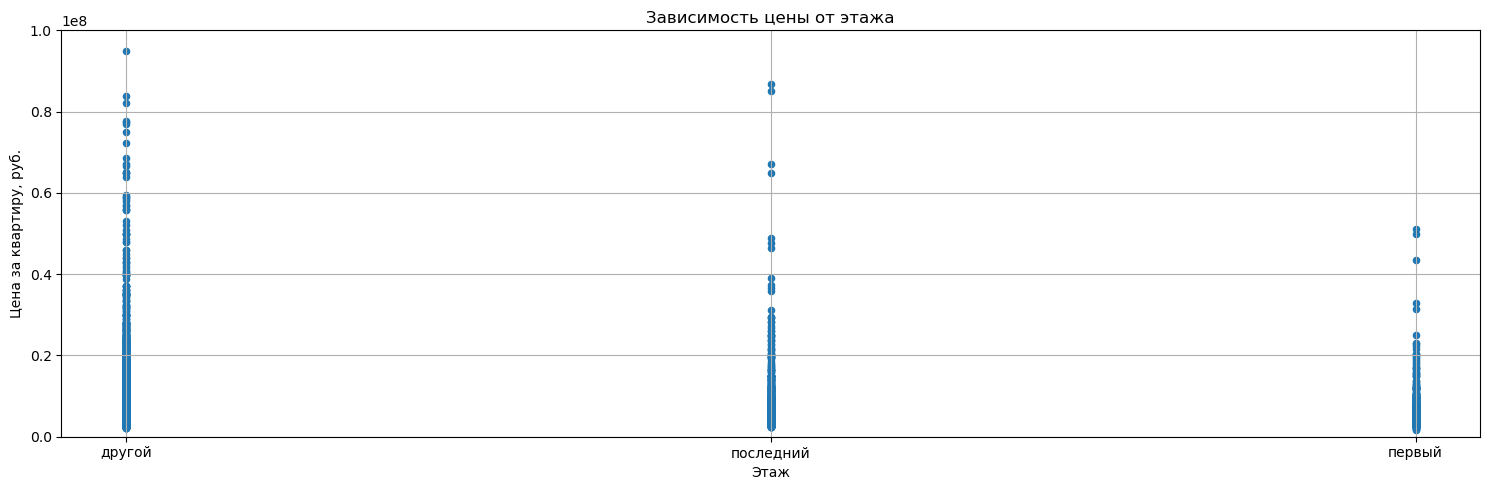

In [73]:
data.plot(kind = 'scatter', 
          grid = True, 
          x = 'type_of_floor',
          xlabel = 'Этаж',
          y = 'last_price',
          ylabel = 'Цена за квартиру, руб.',
          ylim = (0, 1e8),
          figsize =(15,5),
          title = "Зависимость цены от этажа",
         )
plt.tight_layout()
plt.show()

***Вывод по графику:*** *Самые дешевые квартиры расположены на 1 этаже, немного дороже - на последнем, а самые дорогие на остальных этажах.*

## Анализ зависимости цены квартиры от дня размещения объявления

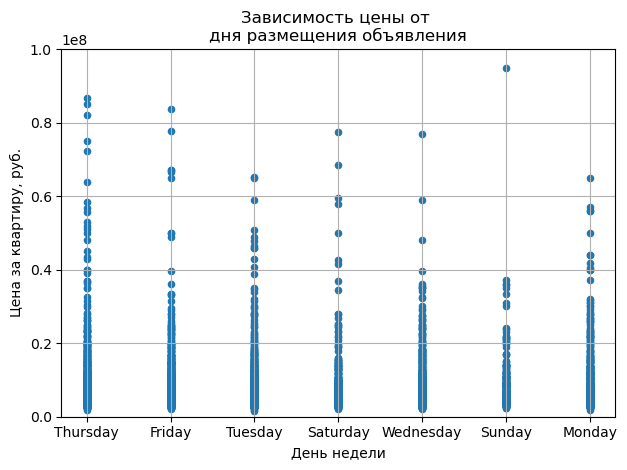

In [74]:
data.plot(
    x = 'day_of_week',
    xlabel = 'День недели',
    y = 'last_price',
    ylabel = 'Цена за квартиру, руб.',
    ylim = (0,1e8),
    kind = 'scatter', 
    grid = True, 
    title = "Зависимость цены от \nдня размещения объявления",
)
plt.tight_layout()
plt.show()

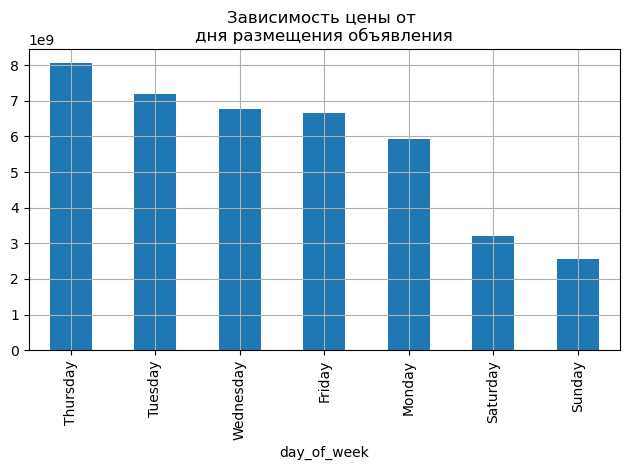

In [75]:
data.groupby(['day_of_week'])['last_price'].sum().sort_values(ascending = False).plot(kind='bar', 
                                                                                      sort_columns = True,
                                                                                      grid = True,
                                                                                     )
plt.title('Зависимость цены от \nдня размещения объявления')
plt.tight_layout()

***Вывод по графику:*** *самые дешевые квартиры в объявлениях, размещенных по воскресеньям, а самые дорогие - по четвергам.*

## Анализ зависимости цены квартиры от месяца размещения объявления

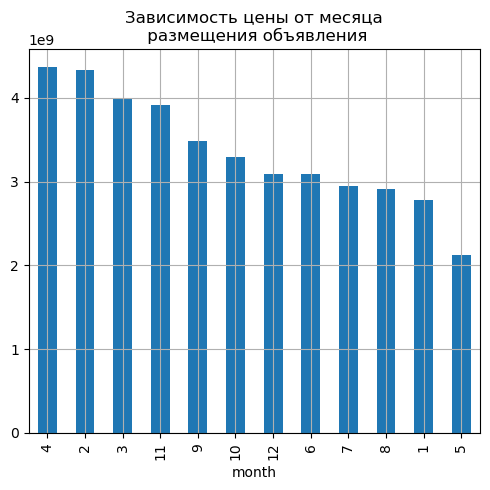

In [76]:
data.groupby(['month'])['last_price'].sum().sort_values(ascending = False).plot(kind='bar', 
                                                                                sort_columns = True,
                                                                                figsize = (5,5),
                                                                                grid = True,
                                                                               )
plt.title('Зависимость цены от месяца\n размещения объявления')
plt.tight_layout()

***Вывод по графику:*** *cамые дорогие квартиры продают в феврале, а самые дешевые - в мае.*

## Анализ зависимости цены квартиры от года размещения объявления

,year,last_price
year,1.000000,-0.059488
last_price,-0.059488,1.000000


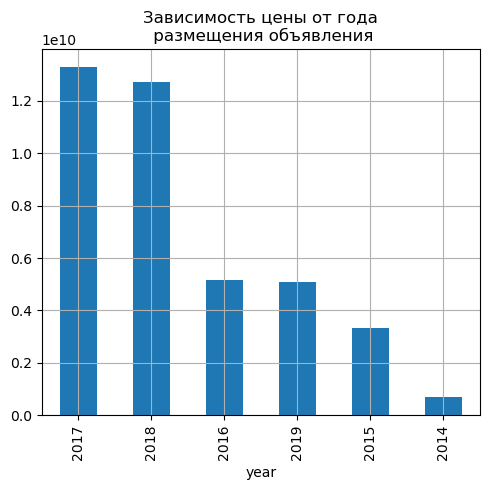

In [77]:
data.groupby(['year'])['last_price'].sum().sort_values(ascending = False).plot(kind='bar', 
                                                                               sort_columns = True,
                                                                               figsize = (5,5),
                                                                               grid = True,
                                                                              )
plt.title('Зависимость цены от года\n размещения объявления')
plt.tight_layout()
data[['year','last_price']].corr()

***Вывод по графику:*** *квартиры дорожали до 2018 года, но в 2019 почему-то подешевели. Возможно потому, что выборка имеет не все данные о квартирах в 2019 года.*

## Расчет средней цены каждого километра до цента в Санкт-Петербурге

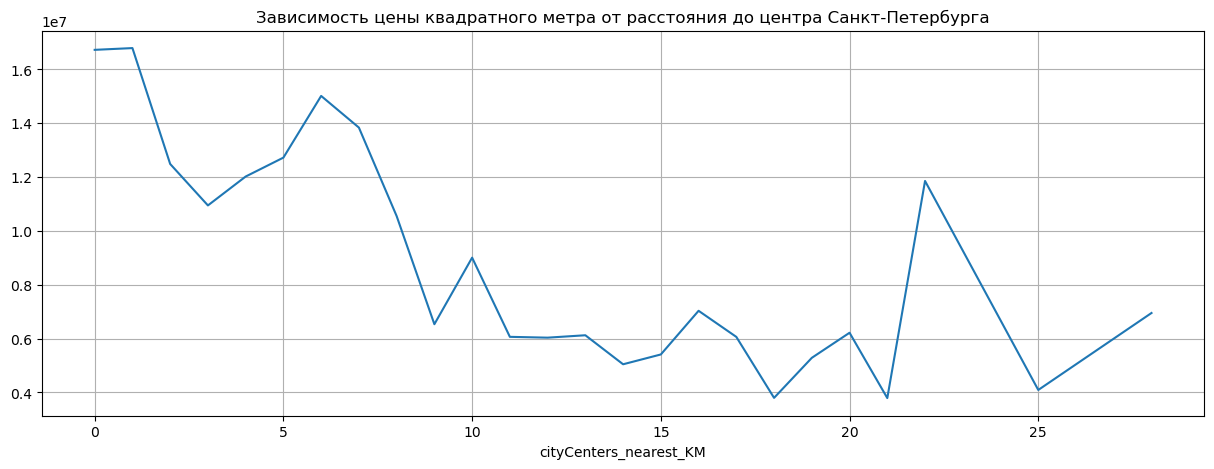

In [78]:
data_spb = data.query('locality_name == "Санкт-Петербург"')
data_spb.groupby('cityCenters_nearest_KM')['last_price'].mean().plot(
    kind = 'line',
    figsize = (15,5),
    grid = True,
    title = 'Зависимость цены квадратного метра от расстояния до центра Санкт-Петербурга'
)
plt.show()

***Вывод:*** *чем дальше от центра, тем дешевее квадратный метр.*

<div>
<i>
    <b>По поводу пиков.</b> Я считаю, что они обусловлены не только расстоянием до центра, но и определенным районом. Я из СПб, и знаю, что есть районы города, где цены на кв.м. гораздо выше, чем в Центральном. Например, район Крестовского острова или Васильевский остров (как раз примерно семи километрах от центра) или Курортный район, питерская "рублевка", (более 25 км от центра) как и Петергоф. Однако, чем объяснить пик в 20 км... Может быть это квартиры в новостройках, опоясывающих Спб.
</i>
</div>

## Корреляционный анализ

In [79]:
data_spb[['last_price','living_area', 'total_area','kitchen_area','rooms','type_of_floor','day_of_week', 'month', 'year']].corr()[['last_price']].sort_values(by = 'last_price', ascending = False).iloc[1:]

,last_price
total_area,0.601297
living_area,0.476125
kitchen_area,0.453084
rooms,0.321332
month,-0.002150
year,-0.062300


<div>
<i>
    Наибольшая зависимость, как я заметил ранее, между ценой квартиры и общей площадью - 0.60, наименьшая корреляция между ценой и месяцем размещения объявления.
</i>
</div>

 ## Список цен на квартиры в населенных пунктах с максимальным числом объявлений

In [80]:
cities = list(data['locality_name'].value_counts().head(10).index)
data.query('locality_name.isin(@cities)').groupby('locality_name')['price_of_metr'].agg(['min', 'mean', 'max', 'median']).sort_values(by = 'mean', ascending = False)

,min,mean,max,median
locality_name,,,,
Санкт-Петербург,17391.30,125685.762989,1736842.11,109596.780
Зеленогорск,88000.00,109891.073125,158225.11,109916.735
Сестрорецк,65102.04,108831.614583,182688.17,103090.715
Пушкин,75172.41,107711.803307,256521.74,103625.000
Павловск,61386.14,91551.960435,161428.57,87209.300
Стрельна,66460.59,88558.942353,116129.03,87741.940
Петергоф,51612.90,86769.150000,225971.73,82815.185
Кронштадт,52033.49,79568.634938,109090.89,80225.080
Колпино,52558.78,76698.438485,125000.00,75202.715


***Вывод:*** *самая высокая средняя цена квадратного метра в Санкт-Петербурге - 113 355 руб., самая низкая - в Выборге - 57 972 руб.*

# Общий вывод
Больше всего на цену квартиры влияет расположение квартиры (город и расстояние до центра) и площадь, т.е. чем крупнее город, ближе к центру и больше площадь, тем дороже квартиры, однако расстояние от центра не всегда является решающим. Есть определенные районы, находящиеся в отдалении, где цены выше.<br>
Помимо расстояния от центра в Питере еще важно, насколько обхекты удалены от метро, хотя таких данных у нас, к сожалению, нет.